#**MEAN REVERSION AND PAIRS TRADING**
---

##0.REFERENCE

https://claude.ai/share/4dcf404a-de2c-41de-ac35-e7f680b92a49

##1.CONTEXT



**Welcome to the World of Mean Reversion**

Mean reversion is one of the most intuitive concepts in financial markets: what goes up must come down, and vice versa. When prices deviate significantly from their historical average, they tend to eventually return to that average. This chapter transforms this simple observation into rigorous, tradeable strategies with proper risk controls.

We begin with single-asset mean reversion, learning to identify when a security has moved "too far" from its normal range using z-scores—a statistical measure of how many standard deviations away from average a price sits. But knowing something has deviated isn't enough; we must determine when to enter, when to exit, and critically, when to admit we were wrong. You'll implement two-threshold hysteresis bands that reduce whipsaw trades, and hard stops that protect capital when mean reversion fails.

**From Singles to Pairs**

The chapter then advances to pairs trading, a market-neutral strategy that profits from the relative mispricing between two related assets. Instead of betting on absolute price direction, we trade the spread between correlated securities. You'll learn why simple correlation isn't enough—relationships break down. We introduce cointegration concepts and dynamic hedge ratios that adapt as market relationships evolve.

**Governance and Rigor**

Every strategy is built with institutional-grade governance: causal signal construction that prevents look-ahead bias, comprehensive diagnostics including half-life estimation to measure reversion speed, and complete audit trails. We use only NumPy—no pandas—forcing explicit, transparent implementations where every calculation is visible and verifiable.

This chapter equips you to build professional mean reversion strategies with disciplined risk management and full accountability.

##2.LIBRARIES AND ENVIRONMENT

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import math
import hashlib
import datetime
import textwrap

# Set deterministic seed
SEED = 42
np.random.seed(SEED)

# Global configuration
CONFIG = {
    "seed": SEED,
    "n_steps": 2000,
    "dt": 1.0,
    "decision_time_convention": "signal computed using data up to t-1; trade applies at t",

    # Windows
    "W_ref": 60,          # Reference window for mean/std
    "W_vol": 60,          # Volatility window
    "W_beta_est": 120,    # Beta estimation window for pairs
    "W_hl": 100,          # Half-life estimation window

    # Thresholds
    "z_in": 2.0,          # Entry threshold (wide)
    "z_out": 0.5,         # Exit threshold (narrow)
    "z_stop": 3.5,        # Hard z-stop threshold

    # Time stop
    "H_max": 100,         # Maximum holding period

    # Exposure cap
    "p_max": 1.0,         # Maximum position size (conceptual cap)

    # Pair selection
    "max_pairs_tested": 50,

    # Synthetic regime parameters
    "regime_params": {
        "mr_kappa": 0.05,      # Mean reversion speed (OU process)
        "mr_sigma": 0.02,      # MR volatility
        "trend_drift": 0.0001, # Trend regime drift
        "trend_sigma": 0.015,  # Trend volatility
        "vol_low": 0.01,       # Low volatility regime
        "vol_high": 0.03,      # High volatility regime
        "pair_common_weight": 0.7,  # Factor loading strength
        "pair_idio_sigma": 0.01     # Idiosyncratic noise
    },

    # Signal computation settings
    "use_median": False,   # False = use mean, True = use median
    "use_mad": False,      # False = use std, True = use MAD
    "cooldown_bars": 0     # Cooldown after exit (0 = off)
}

# Save config immediately
with open('config.json', 'w') as f:
    json.dump(CONFIG, f, indent=2)

print("CONFIG SAVED: config.json")
print(f"Seed: {SEED}")
print(f"Steps: {CONFIG['n_steps']}")
print(f"Decision-time convention: {CONFIG['decision_time_convention']}")

CONFIG SAVED: config.json
Seed: 42
Steps: 2000
Decision-time convention: signal computed using data up to t-1; trade applies at t


##3.SYNTHETIC DATA GENERATOR

###3.1.OVERVIEW



**Why Synthetic Data?**

Before testing strategies on real markets, we need controlled environments where we know the ground truth. Synthetic data lets us verify our code works correctly, understand strategy behavior across different market conditions, and avoid the expensive mistakes that come from deploying untested strategies on live data.

**Single-Asset Multi-Regime Generator**

We construct a price series that transitions through three distinct market regimes: mean-reverting periods where prices oscillate around a stable level (modeled as an Ornstein-Uhlenbeck process), trending periods where prices drift persistently in one direction (random walk with drift), and high-volatility periods with increased price uncertainty. This mimics real markets that alternate between ranging, trending, and stressed conditions. By tracking regime boundaries, we can later diagnose which market environments favor mean reversion strategies and which destroy them.

**Pair Generator with Relationship Breaks**

For pairs trading, we create two correlated assets driven by a common factor—imagine two retailers affected by consumer spending, or two oil companies moving with crude prices. Critically, we introduce a relationship break at the midpoint where the factor loading changes, simulating what happens when business fundamentals diverge (one company shifts strategy, regulatory changes affect them differently, etc.). This tests whether our pairs strategy can detect when historical relationships have deteriorated.

**Governance from the Start**

Every generated series includes metadata: regime change timestamps, factor loadings, and break points. We assert prices remain positive and time flows forward—basic sanity checks that catch bugs early. The visualization plots prices with regime markers, making the data generation transparent and debuggable. This discipline continues throughout the notebook.

###3.2.CODE AND IMPLEMENTATION

In [ ]:

def generate_single_asset_multiregime(n_steps, regime_schedule, params, seed=None):
    """
    Generate single-asset price series with regime switching.

    Regimes:
    0 = mean-reverting (OU/AR1)
    1 = trending (random walk with drift)
    2 = high volatility clustering

    Args:
        n_steps: int, number of time steps
        regime_schedule: array of shape (n_steps,) with regime indices
        params: dict with regime parameters
        seed: random seed

    Returns:
        P: price array (n_steps,)
        X: log price array (n_steps,)
        meta: dict with regime boundaries
    """
    if seed is not None:
        np.random.seed(seed)

    X = np.zeros(n_steps)
    X[0] = 0.0  # Initial log price

    # Extract parameters
    kappa = params['mr_kappa']
    mr_sigma = params['mr_sigma']
    drift = params['trend_drift']
    trend_sigma = params['trend_sigma']
    vol_low = params['vol_low']
    vol_high = params['vol_high']

    # Track regime boundaries
    regime_changes = []
    prev_regime = regime_schedule[0]

    for t in range(1, n_steps):
        regime = regime_schedule[t]

        # Detect regime change
        if regime != prev_regime:
            regime_changes.append(t)
        prev_regime = regime

        # Generate return based on regime
        if regime == 0:
            # Mean-reverting: dX = -kappa * X * dt + sigma * dW
            dX = -kappa * X[t-1] * CONFIG['dt'] + mr_sigma * np.random.randn()
        elif regime == 1:
            # Trending: dX = drift * dt + sigma * dW
            dX = drift * CONFIG['dt'] + trend_sigma * np.random.randn()
        else:  # regime == 2
            # High volatility: random walk with high sigma
            dX = vol_high * np.random.randn()

        X[t] = X[t-1] + dX

    # Convert to price (ensure positive)
    P = np.exp(X)

    # Assertions
    assert P.shape == (n_steps,), "Price array shape mismatch"
    assert np.all(P > 0), "All prices must be positive"
    assert X.shape == (n_steps,), "Log price array shape mismatch"

    meta = {
        'regime_changes': regime_changes,
        'regime_schedule': regime_schedule.tolist()
    }

    return P, X, meta


def generate_pair_with_break(n_steps, break_point, params, seed=None):
    """
    Generate a pair of assets with common factor and relationship break.

    X_A = a + b * F + idio_A
    X_B = c + d * F + idio_B

    At break_point, b changes to simulate relationship breakdown.

    Args:
        n_steps: int, number of time steps
        break_point: int, time index where relationship breaks
        params: dict with pair parameters
        seed: random seed

    Returns:
        P_A, P_B: price arrays
        X_A, X_B: log price arrays
        meta: dict with breakpoints and factor loadings
    """
    if seed is not None:
        np.random.seed(seed)

    # Generate common factor (random walk)
    F = np.zeros(n_steps)
    for t in range(1, n_steps):
        F[t] = F[t-1] + 0.01 * np.random.randn()

    # Parameters
    common_weight = params['pair_common_weight']
    idio_sigma = params['pair_idio_sigma']

    # Initial loadings
    b1 = common_weight
    d1 = common_weight * 0.8  # Slightly different loading

    # Post-break loadings
    b2 = common_weight * 1.5  # Relationship changes
    d2 = d1  # B stays same

    # Generate log prices
    X_A = np.zeros(n_steps)
    X_B = np.zeros(n_steps)

    for t in range(n_steps):
        if t < break_point:
            b_t = b1
        else:
            b_t = b2

        X_A[t] = b_t * F[t] + idio_sigma * np.random.randn()
        X_B[t] = d1 * F[t] + idio_sigma * np.random.randn()

    # Convert to prices
    P_A = np.exp(X_A)
    P_B = np.exp(X_B)

    # Assertions
    assert P_A.shape == (n_steps,), "P_A shape mismatch"
    assert P_B.shape == (n_steps,), "P_B shape mismatch"
    assert np.all(P_A > 0), "All P_A must be positive"
    assert np.all(P_B > 0), "All P_B must be positive"

    meta = {
        'break_point': break_point,
        'b_before': b1,
        'b_after': b2,
        'd': d1
    }

    return P_A, P_B, X_A, X_B, meta


# Generate single-asset data with regime switching
n_steps = CONFIG['n_steps']

# Define regime schedule: 3 regimes switching
regime_schedule = np.zeros(n_steps, dtype=int)
regime_schedule[0:600] = 0      # Mean-reverting
regime_schedule[600:1200] = 1   # Trending
regime_schedule[1200:1600] = 0  # Mean-reverting again
regime_schedule[1600:] = 2      # High volatility

P_single, X_single, meta_single = generate_single_asset_multiregime(
    n_steps, regime_schedule, CONFIG['regime_params'], seed=SEED
)

# Generate pair data with relationship break at midpoint
break_point = n_steps // 2
P_A, P_B, X_A, X_B, meta_pair = generate_pair_with_break(
    n_steps, break_point, CONFIG['regime_params'], seed=SEED+1
)

# Create time index
t_idx = np.arange(n_steps)

# Plot single asset with regime markers
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(t_idx, P_single, linewidth=0.8, label='Price')
for rc in meta_single['regime_changes']:
    plt.axvline(rc, color='red', linestyle='--', alpha=0.5, linewidth=0.8)
plt.title('Single Asset: Price with Regime Changes')
plt.xlabel('Time Index')
plt.ylabel('Price')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(t_idx, P_A, linewidth=0.8, label='Asset A')
plt.plot(t_idx, P_B, linewidth=0.8, label='Asset B')
plt.axvline(break_point, color='red', linestyle='--', alpha=0.7, linewidth=1.0, label='Relationship Break')
plt.title('Pair: Prices with Relationship Break')
plt.xlabel('Time Index')
plt.ylabel('Price')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('synthetic_data.png', dpi=100)
plt.show()

print(f"\nSingle-asset generated: {n_steps} steps")
print(f"Regime changes at: {meta_single['regime_changes']}")
print(f"\nPair generated: {n_steps} steps")
print(f"Relationship break at: {break_point}")


##4.ROLLING UTILITIES

###4.1.OVERVIEW



**Why Build From Scratch?**

We implement every rolling calculation explicitly using NumPy loops rather than using pandas or pre-built functions. This isn't academic purity—it's about understanding and control. When you write the loop yourself, you see exactly which data points enter each calculation, making it impossible to accidentally use future information. In production trading systems, look-ahead bias is a silent killer that makes backtests look profitable while live trading loses money.

**Strict Lagged Windows**

Each rolling function follows an iron law: the value at time t uses only data from [t-W, t), never including t itself. For example, `rolling_mean_lag(x, W)` computes mu[t] as the mean of the W bars ending at t-1. This one-bar lag is critical—when we make a trading decision at time t, we've observed price[t] but our statistics must be computed from the past. The signal is computed using yesterday's window, then applied to today's price movement.

**Robustness Through Choice**

We implement both mean and median for central tendency, and both standard deviation and Median Absolute Deviation (MAD) for dispersion. Why? Markets have fat tails and outliers. A single erroneous tick can corrupt a mean and standard deviation for an entire window, while median and MAD are robust to such contamination. The config allows switching between methods, letting you test sensitivity.

**Unit Tests Verify Causality**

The cell includes explicit verification: we manually recompute the mean for selected time points and assert it matches our function's output. We verify the first W values are NaN (no calculation possible yet). These tests catch subtle indexing bugs before they contaminate your entire backtest.

###4.2.CODE AND IMPLEMENTATION

In [5]:

# ==========================================================
# Cell 4 — Rolling Utilities (NO pandas)
# ==========================================================

def rolling_mean_lag(x, W):
    """
    Compute rolling mean with strict lag: mu[t] uses x[t-W:t].
    Returns np.nan for t < W.

    Args:
        x: array (T,)
        W: window size

    Returns:
        mu: array (T,) with lagged rolling mean
    """
    T = len(x)
    mu = np.full(T, np.nan)

    for t in range(W, T):
        # Use strictly past data: x[t-W:t]
        mu[t] = np.mean(x[t-W:t])

    return mu


def rolling_std_lag(x, W, ddof=1):
    """
    Compute rolling standard deviation with strict lag: sigma[t] uses x[t-W:t].
    Returns np.nan for t < W.

    Args:
        x: array (T,)
        W: window size
        ddof: degrees of freedom for std

    Returns:
        sigma: array (T,) with lagged rolling std
    """
    T = len(x)
    sigma = np.full(T, np.nan)

    for t in range(W, T):
        sigma[t] = np.std(x[t-W:t], ddof=ddof)

    return sigma


def rolling_median_lag(x, W):
    """
    Compute rolling median with strict lag: med[t] uses x[t-W:t].
    Returns np.nan for t < W.
    """
    T = len(x)
    med = np.full(T, np.nan)

    for t in range(W, T):
        med[t] = np.median(x[t-W:t])

    return med


def rolling_mad_lag(x, W):
    """
    Compute rolling Median Absolute Deviation with strict lag.
    MAD = median(|x - median(x)|)
    Returns np.nan for t < W.
    """
    T = len(x)
    mad = np.full(T, np.nan)

    for t in range(W, T):
        window = x[t-W:t]
        med = np.median(window)
        mad[t] = np.median(np.abs(window - med))

    return mad


def zscore_from_ref(x, mu, sigma, eps=1e-8):
    """
    Compute z-score: z = (x - mu) / (sigma + eps)

    Args:
        x: current value array (T,)
        mu: reference mean array (T,)
        sigma: reference std array (T,)
        eps: small constant to avoid division by zero

    Returns:
        z: z-score array (T,)
    """
    z = (x - mu) / (sigma + eps)
    return z


# Unit test: verify lag behavior
print("\n" + "="*60)
print("UNIT TEST: Rolling Utilities Lag Verification")
print("="*60)

# Create small test array
x_test = np.array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0])
W_test = 3

mu_test = rolling_mean_lag(x_test, W_test)
sigma_test = rolling_std_lag(x_test, W_test)

print(f"\nTest array: {x_test}")
print(f"Window W = {W_test}")
print(f"\nRolling mean (lagged):")
for i, val in enumerate(mu_test):
    if not np.isnan(val):
        expected_window = x_test[i-W_test:i]
        expected_mean = np.mean(expected_window)
        print(f"  t={i}: mu={val:.4f}, expected={expected_mean:.4f}, window={expected_window}")
        assert abs(val - expected_mean) < 1e-10, f"Mismatch at t={i}"

# Specific causality test: mu[W] should use x[0:W] (not including x[W])
assert abs(mu_test[W_test] - np.mean(x_test[0:W_test])) < 1e-10, "Causality violation at t=W"
print(f"\n✓ Causality verified: mu[{W_test}] = mean(x[0:{W_test}]) = {mu_test[W_test]:.4f}")

# Test that first W-1 values are NaN
assert np.all(np.isnan(mu_test[:W_test])), "First W values should be NaN"
print(f"✓ First {W_test} values are NaN as expected")



UNIT TEST: Rolling Utilities Lag Verification

Test array: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
Window W = 3

Rolling mean (lagged):
  t=3: mu=2.0000, expected=2.0000, window=[1. 2. 3.]
  t=4: mu=3.0000, expected=3.0000, window=[2. 3. 4.]
  t=5: mu=4.0000, expected=4.0000, window=[3. 4. 5.]
  t=6: mu=5.0000, expected=5.0000, window=[4. 5. 6.]
  t=7: mu=6.0000, expected=6.0000, window=[5. 6. 7.]
  t=8: mu=7.0000, expected=7.0000, window=[6. 7. 8.]
  t=9: mu=8.0000, expected=8.0000, window=[7. 8. 9.]

✓ Causality verified: mu[3] = mean(x[0:3]) = 2.0000
✓ First 3 values are NaN as expected


##5.SINGLE ASSET SIGNAL CONSTRUCTION

###5.1.OVERVIEW



**Building the Z-Score Signal**

This cell transforms raw prices into a standardized trading signal that answers one question: "How far has this asset deviated from normal?" We work with log prices (X = log(P)) because they have better statistical properties—returns become additive, and percentage moves are symmetric. The deviation is simply current log price minus its rolling average: how far above or below "normal" are we right now?

**Normalization Through Z-Scores**

Raw deviation isn't enough because volatility changes over time. A 2-point deviation means something very different in a calm market versus a turbulent one. The z-score normalizes by dividing deviation by rolling standard deviation, giving us a volatility-adjusted measure. A z-score of +2.0 means "two standard deviations above average"—a consistent definition regardless of whether we're trading a sleepy utility stock or a volatile tech name.

**Tail Statistics Reveal Regime**

We compute percentiles (1%, 5%, 95%, 99%) of the z-score distribution to understand the signal's behavior. In a perfect Gaussian world, we'd see ±2.0 at roughly the 2.5% and 97.5% levels. Real market data shows fatter tails—extreme moves happen more often than normal distributions predict. These statistics guide threshold selection: if 95% of z-scores fall within ±1.5, then using ±2.0 entry thresholds means we're only trading genuine extremes.

**Causality Assertions as Insurance**

We randomly select time points and manually verify that mu[t] equals the mean of exactly x[t-W:t]—no future data included. This paranoid checking catches indexing errors that would invalidate every subsequent result. The plots show z-scores with entry thresholds overlaid, making the signal's behavior visual and interpretable before we risk any capital.

###5.2.CODE AND IMPLEMENTATION


SINGLE-ASSET SIGNAL CONSTRUCTION

Causality Assertion Check:
  t=60: mu_ref=-0.050642, expected=-0.050642 ✓
  t=160: mu_ref=-0.014099, expected=-0.014099 ✓
  t=560: mu_ref=-0.075875, expected=-0.075875 ✓
  t=1900: mu_ref=0.418030, expected=0.418030 ✓

Z-Score Tail Statistics:
  1%:  -3.0600
  5%:  -1.9976
  25%: -0.8054
  50%: 0.3817
  75%: 1.3547
  95%: 2.3124
  99%: 3.0494


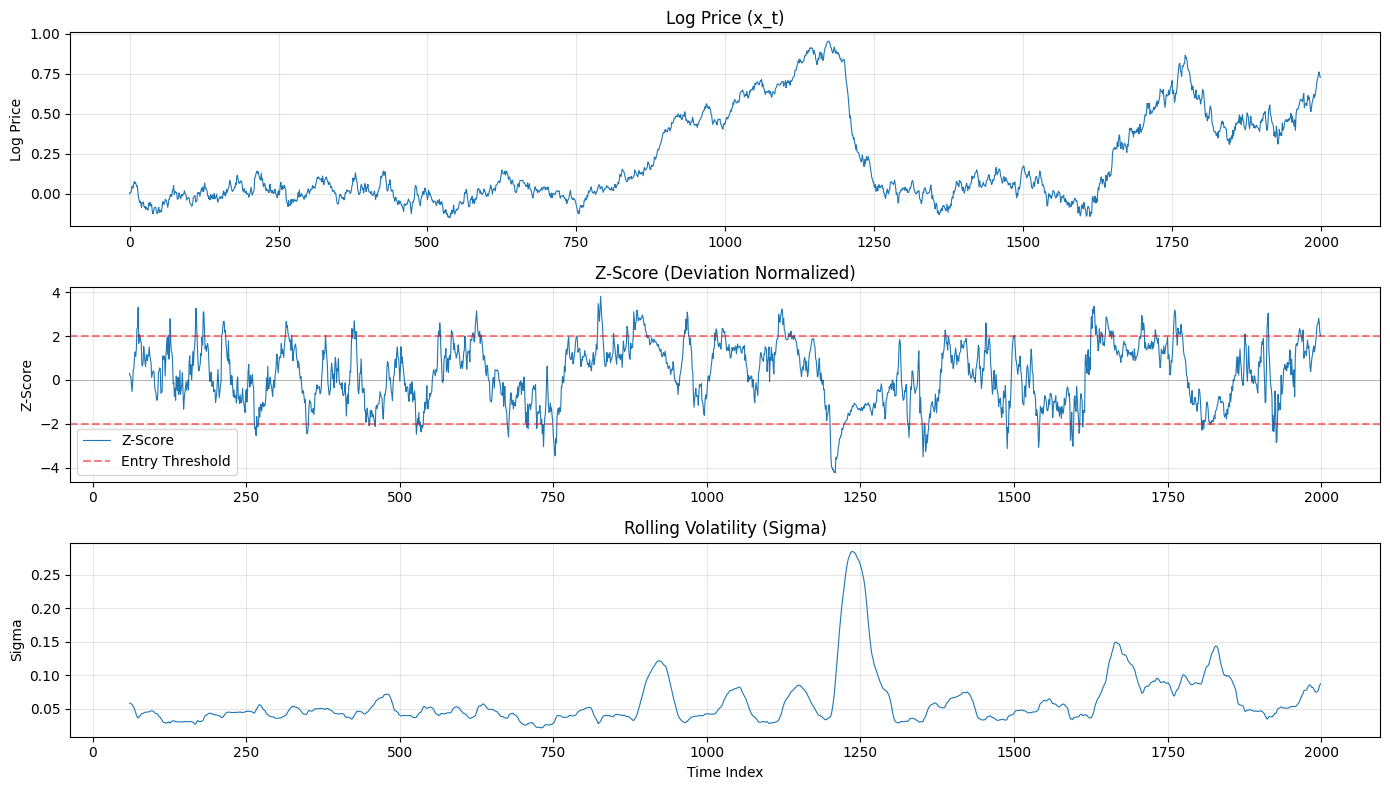


SIGNAL REGISTRY SAVED: signal_registry.json


In [6]:

print("\n" + "="*60)
print("SINGLE-ASSET SIGNAL CONSTRUCTION")
print("="*60)

# Choose log price as trading object
x_t = X_single.copy()

# Extract config
W_ref = CONFIG['W_ref']
use_median = CONFIG['use_median']
use_mad = CONFIG['use_mad']

# Compute reference statistics (lagged)
if use_median:
    mu_ref = rolling_median_lag(x_t, W_ref)
else:
    mu_ref = rolling_mean_lag(x_t, W_ref)

if use_mad:
    sigma_ref = rolling_mad_lag(x_t, W_ref)
    # MAD needs scaling for Gaussian comparison
    sigma_ref = sigma_ref * 1.4826  # Approximate std equivalent
else:
    sigma_ref = rolling_std_lag(x_t, W_ref)

# Compute deviation and z-score
deviation = x_t - mu_ref
z_single = zscore_from_ref(x_t, mu_ref, sigma_ref, eps=1e-8)

# Causality assertion: verify at random time points
print("\nCausality Assertion Check:")
check_times = [W_ref, W_ref + 100, W_ref + 500, n_steps - 100]
for t in check_times:
    if t < len(x_t):
        window = x_t[t-W_ref:t]
        if use_median:
            expected_mu = np.median(window)
        else:
            expected_mu = np.mean(window)

        actual_mu = mu_ref[t]
        if not np.isnan(actual_mu):
            assert abs(actual_mu - expected_mu) < 1e-8, f"Causality violation at t={t}"
            print(f"  t={t}: mu_ref={actual_mu:.6f}, expected={expected_mu:.6f} ✓")

# Tail statistics
valid_z = z_single[~np.isnan(z_single)]
z_percentiles = np.percentile(valid_z, [1, 5, 25, 50, 75, 95, 99])

print(f"\nZ-Score Tail Statistics:")
print(f"  1%:  {z_percentiles[0]:.4f}")
print(f"  5%:  {z_percentiles[1]:.4f}")
print(f"  25%: {z_percentiles[2]:.4f}")
print(f"  50%: {z_percentiles[3]:.4f}")
print(f"  75%: {z_percentiles[4]:.4f}")
print(f"  95%: {z_percentiles[5]:.4f}")
print(f"  99%: {z_percentiles[6]:.4f}")

# Plot z-score and volatility
plt.figure(figsize=(14, 8))

plt.subplot(3, 1, 1)
plt.plot(t_idx, x_t, linewidth=0.8)
plt.title('Log Price (x_t)')
plt.ylabel('Log Price')
plt.grid(alpha=0.3)

plt.subplot(3, 1, 2)
plt.plot(t_idx, z_single, linewidth=0.8, label='Z-Score')
plt.axhline(0, color='black', linestyle='-', alpha=0.3, linewidth=0.5)
plt.axhline(CONFIG['z_in'], color='red', linestyle='--', alpha=0.5, label='Entry Threshold')
plt.axhline(-CONFIG['z_in'], color='red', linestyle='--', alpha=0.5)
plt.title('Z-Score (Deviation Normalized)')
plt.ylabel('Z-Score')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(3, 1, 3)
plt.plot(t_idx, sigma_ref, linewidth=0.8)
plt.title('Rolling Volatility (Sigma)')
plt.xlabel('Time Index')
plt.ylabel('Sigma')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('single_asset_signals.png', dpi=100)
plt.show()

# Save signal registry
signal_registry = {
    "signals": {
        "deviation": {
            "definition": "x_t - mu_ref_t",
            "units": "log price units",
            "window": W_ref,
            "reference_type": "median" if use_median else "mean"
        },
        "z_score": {
            "definition": "(x_t - mu_ref_t) / (sigma_ref_t + eps)",
            "units": "standard deviations",
            "window": W_ref,
            "volatility_type": "MAD" if use_mad else "std",
            "eps": 1e-8
        },
        "sigma_ref": {
            "definition": "rolling std or MAD",
            "units": "log price units",
            "window": W_ref,
            "type": "MAD" if use_mad else "std"
        }
    }
}

with open('signal_registry.json', 'w') as f:
    json.dump(signal_registry, f, indent=2)

print("\nSIGNAL REGISTRY SAVED: signal_registry.json")



##6.STRATEGY 1. TWO THRESHOLD HYSTERISIS

###6.1.OVERVIEW


**The Whipsaw Problem**

A naive mean reversion strategy using a single threshold creates a deadly pattern: enter long when z drops below -2.0, exit when it crosses back above -2.0. But what if the price oscillates around that threshold? You'll enter, exit, re-enter, exit again—generating transaction costs while capturing no trend. This "whipsawing" destroys profitability through excessive trading.

**Hysteresis: Wide Entry, Narrow Exit**

We solve this with two thresholds creating a "dead zone." Enter long only when z reaches -2.0 (extreme deviation), but don't exit until z recovers to -0.5 (closer to normal). This asymmetry means you need a significant deviation to trigger a position, but only a partial recovery to close it. The wider entry threshold filters out noise; the narrower exit threshold allows you to capture mean reversion profit before the full reversal completes. Think of it like a thermostat with different on/off temperatures—preventing constant cycling.

**State Machine Implementation**

We track three states explicitly: FLAT (no position), LONG (+1), or SHORT (-1). The rules are deterministic: from FLAT, enter LONG if z ≤ -z_in or SHORT if z ≥ +z_in. Once in a position, exit only when crossing the narrower z_out threshold. This state machine approach makes the logic transparent and debuggable—you can trace every position change with exact reasons.

**Performance Metrics That Matter**

We compute total return, maximum drawdown (worst peak-to-trough equity decline), average holding time, and turnover (position changes). These metrics reveal strategy characteristics: does it hold positions long enough to overcome costs? How deep are the drawdowns during adverse regimes? The equity curve visualization shows cumulative profit, while trade markers on the z-score plot reveal entry/exit timing discipline.

###6.2.CODE AND IMPLEMENTATION


STRATEGY 1: TWO-THRESHOLD HYSTERESIS

Strategy 1 Performance:
  Total Return: -0.051764
  Max Drawdown: -1.428312
  Avg Holding Time: 24.54 bars
  Position Changes: 83
  Number of Trades: 41


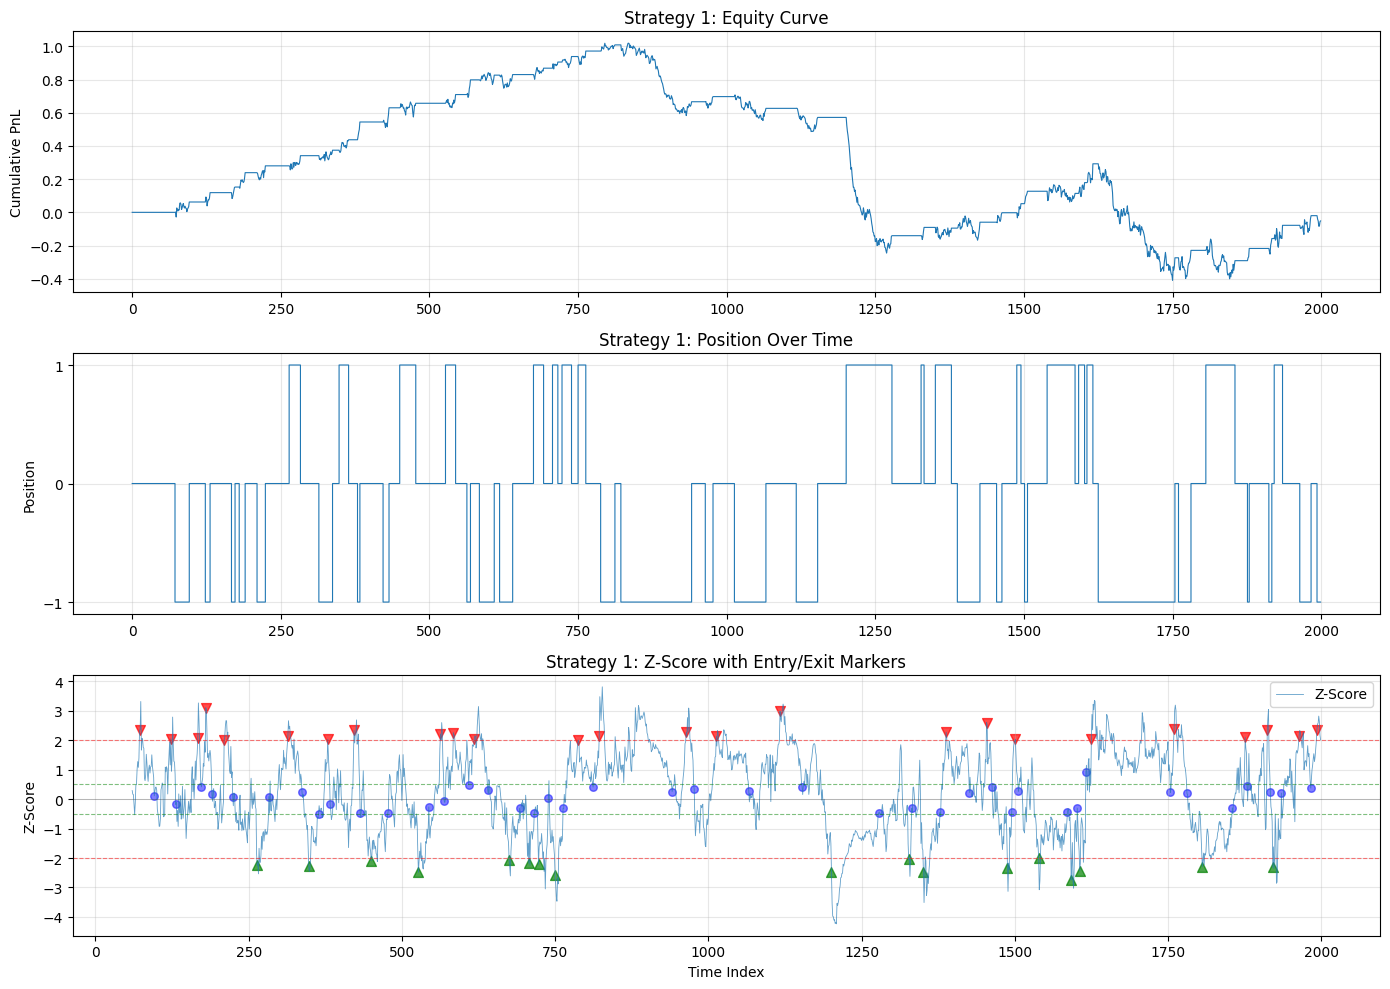


STRATEGY MANIFEST SAVED: strategy_manifest.json


In [7]:

print("\n" + "="*60)
print("STRATEGY 1: TWO-THRESHOLD HYSTERESIS")
print("="*60)

def strategy_hysteresis(z, z_in, z_out, cooldown_bars=0):
    """
    Implement two-threshold hysteresis trading strategy.

    State machine: FLAT (0), LONG (1), SHORT (-1)

    Entry (from flat):
        - z <= -z_in => LONG
        - z >= +z_in => SHORT

    Exit (from position):
        - LONG and z >= -z_out => FLAT
        - SHORT and z <= +z_out => FLAT

    Args:
        z: z-score array (T,)
        z_in: entry threshold (wide)
        z_out: exit threshold (narrow)
        cooldown_bars: minimum bars to wait after exit before re-entry

    Returns:
        p: position array (T,) in {-1, 0, +1}
        state_log: list of (time, state, reason) tuples
    """
    T = len(z)
    p = np.zeros(T)
    state = 0  # 0=flat, 1=long, -1=short
    cooldown_counter = 0
    state_log = []

    for t in range(T):
        if np.isnan(z[t]):
            p[t] = 0
            continue

        # Decrement cooldown
        if cooldown_counter > 0:
            cooldown_counter -= 1

        # State transitions
        if state == 0:  # FLAT
            if cooldown_counter == 0:
                if z[t] <= -z_in:
                    state = 1  # Enter LONG
                    state_log.append((t, 1, 'enter_long'))
                elif z[t] >= z_in:
                    state = -1  # Enter SHORT
                    state_log.append((t, -1, 'enter_short'))

        elif state == 1:  # LONG
            if z[t] >= -z_out:
                state = 0  # Exit to FLAT
                cooldown_counter = cooldown_bars
                state_log.append((t, 0, 'exit_long'))

        elif state == -1:  # SHORT
            if z[t] <= z_out:
                state = 0  # Exit to FLAT
                cooldown_counter = cooldown_bars
                state_log.append((t, 0, 'exit_short'))

        p[t] = state

    return p, state_log


# Run strategy
z_in = CONFIG['z_in']
z_out = CONFIG['z_out']
cooldown = CONFIG['cooldown_bars']

p_s1, state_log_s1 = strategy_hysteresis(z_single, z_in, z_out, cooldown)

# Compute PnL
# Use simple log returns: r[t] = x[t+1] - x[t]
# PnL[t] = p[t] * r[t+1] where p[t] is position at time t applied to t->t+1
r_single = np.diff(x_t, prepend=x_t[0])  # r[t] = x[t] - x[t-1], shifted
r_single[0] = 0.0

pnl_s1 = np.zeros(n_steps)
for t in range(n_steps - 1):
    pnl_s1[t+1] = p_s1[t] * (x_t[t+1] - x_t[t])

# Cumulative PnL (equity curve)
equity_s1 = np.cumsum(pnl_s1)

# Performance metrics
total_return_s1 = equity_s1[-1]

# Max drawdown
def compute_max_drawdown(equity):
    """Compute maximum drawdown from equity curve."""
    running_max = np.maximum.accumulate(equity)
    drawdown = equity - running_max
    max_dd = np.min(drawdown)
    return max_dd

max_dd_s1 = compute_max_drawdown(equity_s1)

# Average holding time
holding_times = []
if len(state_log_s1) > 0:
    entry_time = None
    for t, state, reason in state_log_s1:
        if 'enter' in reason:
            entry_time = t
        elif 'exit' in reason and entry_time is not None:
            holding_times.append(t - entry_time)
            entry_time = None

avg_holding = np.mean(holding_times) if len(holding_times) > 0 else 0.0

# Turnover proxy: count position changes
turnover_s1 = np.sum(np.abs(np.diff(p_s1)) > 0)

print(f"\nStrategy 1 Performance:")
print(f"  Total Return: {total_return_s1:.6f}")
print(f"  Max Drawdown: {max_dd_s1:.6f}")
print(f"  Avg Holding Time: {avg_holding:.2f} bars")
print(f"  Position Changes: {turnover_s1}")
print(f"  Number of Trades: {len(holding_times)}")

# Plot
plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
plt.plot(t_idx, equity_s1, linewidth=0.8)
plt.title('Strategy 1: Equity Curve')
plt.ylabel('Cumulative PnL')
plt.grid(alpha=0.3)

plt.subplot(3, 1, 2)
plt.plot(t_idx, p_s1, linewidth=0.8, drawstyle='steps-post')
plt.title('Strategy 1: Position Over Time')
plt.ylabel('Position')
plt.yticks([-1, 0, 1])
plt.grid(alpha=0.3)

plt.subplot(3, 1, 3)
plt.plot(t_idx, z_single, linewidth=0.6, alpha=0.7, label='Z-Score')
plt.axhline(0, color='black', linestyle='-', alpha=0.3, linewidth=0.5)
plt.axhline(z_in, color='red', linestyle='--', alpha=0.5, linewidth=0.8)
plt.axhline(-z_in, color='red', linestyle='--', alpha=0.5, linewidth=0.8)
plt.axhline(z_out, color='green', linestyle='--', alpha=0.5, linewidth=0.8)
plt.axhline(-z_out, color='green', linestyle='--', alpha=0.5, linewidth=0.8)

# Mark entry/exit points
for t, state, reason in state_log_s1:
    if 'enter_long' in reason:
        plt.scatter(t, z_single[t], color='green', marker='^', s=50, alpha=0.7)
    elif 'enter_short' in reason:
        plt.scatter(t, z_single[t], color='red', marker='v', s=50, alpha=0.7)
    elif 'exit' in reason:
        plt.scatter(t, z_single[t], color='blue', marker='o', s=30, alpha=0.5)

plt.title('Strategy 1: Z-Score with Entry/Exit Markers')
plt.xlabel('Time Index')
plt.ylabel('Z-Score')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('strategy1_hysteresis.png', dpi=100)
plt.show()

# Save strategy manifest
strategy_manifest = {
    "strategy_1_hysteresis": {
        "type": "two_threshold_hysteresis",
        "z_in": z_in,
        "z_out": z_out,
        "cooldown_bars": cooldown,
        "decision_convention": CONFIG['decision_time_convention']
    }
}

with open('strategy_manifest.json', 'w') as f:
    json.dump(strategy_manifest, f, indent=2)

print("\nSTRATEGY MANIFEST SAVED: strategy_manifest.json")


##7.ADDING AN ADMISSION OF MISTAKES

###7.1.OVERVIEW


**When Mean Reversion Fails**

Mean reversion doesn't work all the time. Markets can trend for extended periods, or undergo structural breaks where the "normal" level permanently shifts. Strategy 1 assumes prices always revert, but what if you're long and the asset keeps falling? Or you've held a position for months with no resolution? Without exit rules for failure cases, a mean reversion strategy can suffer catastrophic losses when the regime changes.

**Z-Stop: The "This Isn't Reverting" Exit**

We add a hard z-stop threshold beyond our entry point. If we entered long at z = -2.0 expecting reversion, but instead z plunges to -3.5, we're not seeing mean reversion—we're seeing a trend or structural break. The z-stop forces us to exit and accept a loss rather than holding through disaster. This is admitting you were wrong about the regime: the expected bounce didn't materialize, so cut the position.

**Time-Stop: The "Taking Too Long" Exit**

Even if z hasn't hit the disaster threshold, holding a position for 100+ bars with no resolution suggests something is broken. Markets that truly mean-revert do so relatively quickly—half-lives are typically measured in days or weeks, not months. The time-stop prevents you from tying up capital indefinitely in positions going nowhere, freeing that capital for fresh opportunities.

**Trade Forensics**

We track detailed per-trade metadata: entry time, exit time, holding period, exit reason (normal profit-taking, z-stop, or time-stop), and maximum adverse excursion (how far against you the trade moved). These statistics reveal strategy health. If most exits are stops rather than normal profit-taking, your entry logic needs refinement. The holding period distribution shows whether you're capturing quick reversions or grinding through extended holds.

###7.2.CODE AND IMPLEMENTATION


STRATEGY 2: HYSTERESIS + STOPS

Strategy 2 Performance (with stops):
  Total Return: 0.020252
  Max Drawdown: -1.356296
  Position Changes: 85
  Number of Trades: 55

Holding Period Distribution:
  Min: 1
  Median: 10.00
  Max: 100
  Mean: 17.95

Exit Reason Frequencies:
  Normal Exit: 40
  Z-Stop: 13
  Time-Stop: 2


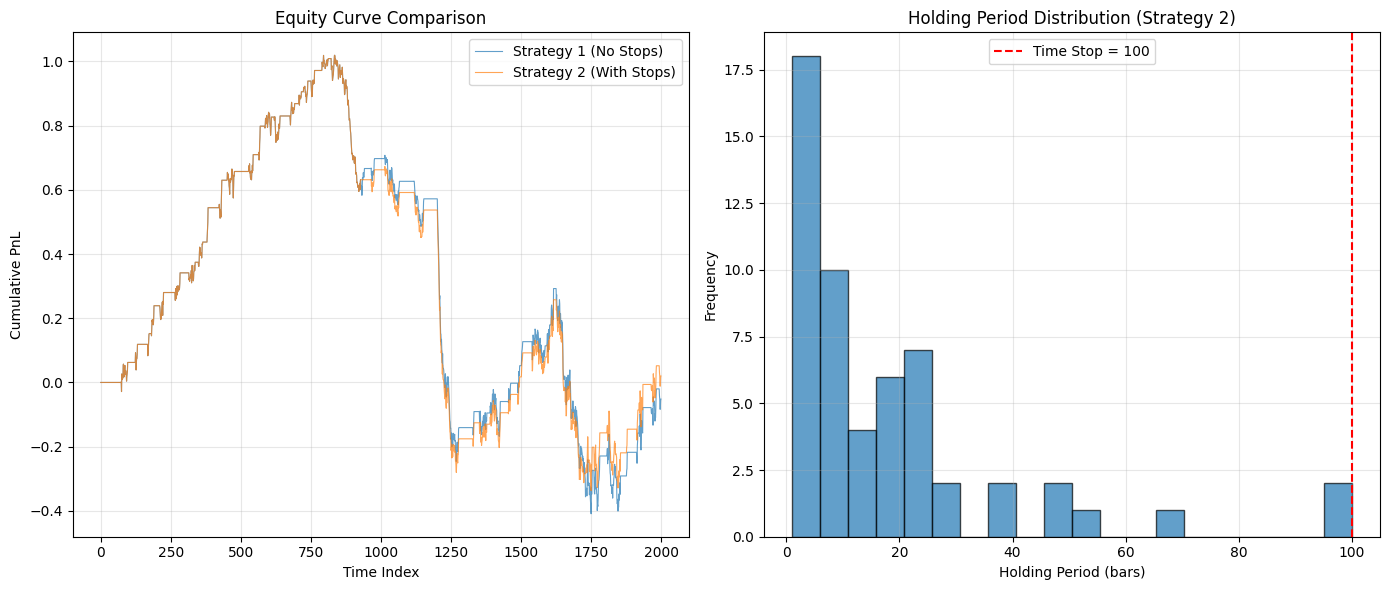

In [8]:

# ==========================================================
# Cell 7 — Strategy 2: Add "Admit You Were Wrong" Stops
# ==========================================================

print("\n" + "="*60)
print("STRATEGY 2: HYSTERESIS + STOPS")
print("="*60)

def strategy_hysteresis_with_stops(z, z_in, z_out, z_stop, H_max, cooldown_bars=0):
    """
    Hysteresis strategy with hard z-stop and time-stop.

    Stops:
        - Z-stop: if in LONG and z <= -z_stop => exit
                  if in SHORT and z >= +z_stop => exit
        - Time-stop: if held for >= H_max bars => exit

    Returns:
        p: position array
        state_log: state transitions
        trade_log: per-trade metadata
    """
    T = len(z)
    p = np.zeros(T)
    state = 0
    cooldown_counter = 0
    state_log = []
    trade_log = []

    # Track current trade
    entry_time = None
    max_adverse_z = None

    for t in range(T):
        if np.isnan(z[t]):
            p[t] = 0
            continue

        if cooldown_counter > 0:
            cooldown_counter -= 1

        # Track max adverse excursion
        if state != 0:
            if state == 1:  # LONG
                if max_adverse_z is None or z[t] > max_adverse_z:
                    max_adverse_z = z[t]
            elif state == -1:  # SHORT
                if max_adverse_z is None or z[t] < max_adverse_z:
                    max_adverse_z = z[t]

        # Check stops first
        if state == 1:  # LONG
            # Z-stop
            if z[t] <= -z_stop:
                trade_log.append({
                    'entry_t': entry_time,
                    'exit_t': t,
                    'holding_period': t - entry_time,
                    'exit_reason': 'z_stop',
                    'max_adverse_z': max_adverse_z
                })
                state = 0
                cooldown_counter = cooldown_bars
                state_log.append((t, 0, 'z_stop_long'))
                entry_time = None
                max_adverse_z = None
            # Time stop
            elif entry_time is not None and (t - entry_time) >= H_max:
                trade_log.append({
                    'entry_t': entry_time,
                    'exit_t': t,
                    'holding_period': t - entry_time,
                    'exit_reason': 'time_stop',
                    'max_adverse_z': max_adverse_z
                })
                state = 0
                cooldown_counter = cooldown_bars
                state_log.append((t, 0, 'time_stop_long'))
                entry_time = None
                max_adverse_z = None
            # Normal exit
            elif z[t] >= -z_out:
                trade_log.append({
                    'entry_t': entry_time,
                    'exit_t': t,
                    'holding_period': t - entry_time,
                    'exit_reason': 'normal_exit',
                    'max_adverse_z': max_adverse_z
                })
                state = 0
                cooldown_counter = cooldown_bars
                state_log.append((t, 0, 'exit_long'))
                entry_time = None
                max_adverse_z = None

        elif state == -1:  # SHORT
            # Z-stop
            if z[t] >= z_stop:
                trade_log.append({
                    'entry_t': entry_time,
                    'exit_t': t,
                    'holding_period': t - entry_time,
                    'exit_reason': 'z_stop',
                    'max_adverse_z': max_adverse_z
                })
                state = 0
                cooldown_counter = cooldown_bars
                state_log.append((t, 0, 'z_stop_short'))
                entry_time = None
                max_adverse_z = None
            # Time stop
            elif entry_time is not None and (t - entry_time) >= H_max:
                trade_log.append({
                    'entry_t': entry_time,
                    'exit_t': t,
                    'holding_period': t - entry_time,
                    'exit_reason': 'time_stop',
                    'max_adverse_z': max_adverse_z
                })
                state = 0
                cooldown_counter = cooldown_bars
                state_log.append((t, 0, 'time_stop_short'))
                entry_time = None
                max_adverse_z = None
            # Normal exit
            elif z[t] <= z_out:
                trade_log.append({
                    'entry_t': entry_time,
                    'exit_t': t,
                    'holding_period': t - entry_time,
                    'exit_reason': 'normal_exit',
                    'max_adverse_z': max_adverse_z
                })
                state = 0
                cooldown_counter = cooldown_bars
                state_log.append((t, 0, 'exit_short'))
                entry_time = None
                max_adverse_z = None

        # Entry logic (from flat)
        if state == 0 and cooldown_counter == 0:
            if z[t] <= -z_in:
                state = 1
                entry_time = t
                max_adverse_z = z[t]
                state_log.append((t, 1, 'enter_long'))
            elif z[t] >= z_in:
                state = -1
                entry_time = t
                max_adverse_z = z[t]
                state_log.append((t, -1, 'enter_short'))

        p[t] = state

    return p, state_log, trade_log


# Run strategy with stops
z_stop = CONFIG['z_stop']
H_max = CONFIG['H_max']

p_s2, state_log_s2, trade_log_s2 = strategy_hysteresis_with_stops(
    z_single, z_in, z_out, z_stop, H_max, cooldown
)

# Compute PnL
pnl_s2 = np.zeros(n_steps)
for t in range(n_steps - 1):
    pnl_s2[t+1] = p_s2[t] * (x_t[t+1] - x_t[t])

equity_s2 = np.cumsum(pnl_s2)

# Performance metrics
total_return_s2 = equity_s2[-1]
max_dd_s2 = compute_max_drawdown(equity_s2)
turnover_s2 = np.sum(np.abs(np.diff(p_s2)) > 0)

# Trade statistics
holding_periods = [t['holding_period'] for t in trade_log_s2]
z_stop_count = sum(1 for t in trade_log_s2 if t['exit_reason'] == 'z_stop')
time_stop_count = sum(1 for t in trade_log_s2 if t['exit_reason'] == 'time_stop')
normal_exit_count = sum(1 for t in trade_log_s2 if t['exit_reason'] == 'normal_exit')

print(f"\nStrategy 2 Performance (with stops):")
print(f"  Total Return: {total_return_s2:.6f}")
print(f"  Max Drawdown: {max_dd_s2:.6f}")
print(f"  Position Changes: {turnover_s2}")
print(f"  Number of Trades: {len(trade_log_s2)}")
print(f"\nHolding Period Distribution:")
if len(holding_periods) > 0:
    print(f"  Min: {np.min(holding_periods)}")
    print(f"  Median: {np.median(holding_periods):.2f}")
    print(f"  Max: {np.max(holding_periods)}")
    print(f"  Mean: {np.mean(holding_periods):.2f}")
print(f"\nExit Reason Frequencies:")
print(f"  Normal Exit: {normal_exit_count}")
print(f"  Z-Stop: {z_stop_count}")
print(f"  Time-Stop: {time_stop_count}")

# Plot comparison
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(t_idx, equity_s1, linewidth=0.8, label='Strategy 1 (No Stops)', alpha=0.7)
plt.plot(t_idx, equity_s2, linewidth=0.8, label='Strategy 2 (With Stops)', alpha=0.7)
plt.title('Equity Curve Comparison')
plt.xlabel('Time Index')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
if len(holding_periods) > 0:
    plt.hist(holding_periods, bins=20, alpha=0.7, edgecolor='black')
    plt.axvline(H_max, color='red', linestyle='--', linewidth=1.5, label=f'Time Stop = {H_max}')
    plt.title('Holding Period Distribution (Strategy 2)')
    plt.xlabel('Holding Period (bars)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('strategy2_with_stops.png', dpi=100)
plt.show()

# Update manifest
strategy_manifest["strategy_2_with_stops"] = {
    "type": "two_threshold_hysteresis_with_stops",
    "z_in": z_in,
    "z_out": z_out,
    "z_stop": z_stop,
    "H_max": H_max,
    "cooldown_bars": cooldown,
    "decision_convention": CONFIG['decision_time_convention']
}

with open('strategy_manifest.json', 'w') as f:
    json.dump(strategy_manifest, f, indent=2)


##8.REVERSION SPEED DIAGNOSTICS

###8.1.OVERVIEW



**Why Reversion Speed Matters**

Not all mean reversion is created equal. Some assets snap back to their average within days; others drift back slowly over months. This speed determines everything: how long you'll hold positions, how much capital gets tied up, whether transaction costs will overwhelm profits. If half-life is 100 bars but your typical holding time is 10 bars, you're exiting before reversion completes. Understanding reversion speed transforms trading from guesswork into calibrated expectation.

**The AR(1) Model**

We model the deviation as an autoregressive process: deviation[t] = φ × deviation[t-1] + noise. The coefficient φ tells us everything. If φ = 0.95, today's deviation is 95% of yesterday's—slow reversion. If φ = 0.50, deviations decay rapidly. When φ ≥ 1.0, we have a unit root: no mean reversion at all, just random walk behavior. This is a regime warning sign.

**Half-Life: The Intuitive Metric**

Half-life answers: "How many bars until the deviation shrinks by 50%?" It's computed as log(0.5)/log(φ). A half-life of 10 bars means quick reversion—positions resolve fast. A half-life of 200 bars suggests grinding, slow convergence where holding costs accumulate. We estimate this in rolling windows because reversion speed isn't constant—it changes with market regime.

**Rolling Diagnostics Reveal Regime Shifts**

By plotting half-life over time with regime markers, we see when mean reversion strengthens or weakens. During trending regimes, φ approaches 1.0 and half-life explodes toward infinity—the strategy's edge has disappeared. The diagnostics also show what fraction of time φ ≥ 1, quantifying how often we're in non-reverting conditions. This informs position sizing: reduce exposure when half-lives extend, indicating weak reversion.

###8.2.CODE AND IMPLEMENTATION


REVERSION SPEED DIAGNOSTICS: AR(1) AND HALF-LIFE

AR(1) Diagnostics on Deviation:
  Median phi: 0.9427
  Phi 10%/90% quantiles: [0.85121323 0.98333276]
  Fraction |phi| >= 1: 0.0239

Half-Life Statistics:
  Median: 11.53 bars
  10%/90% quantiles: [ 4.13990154 34.70368278]


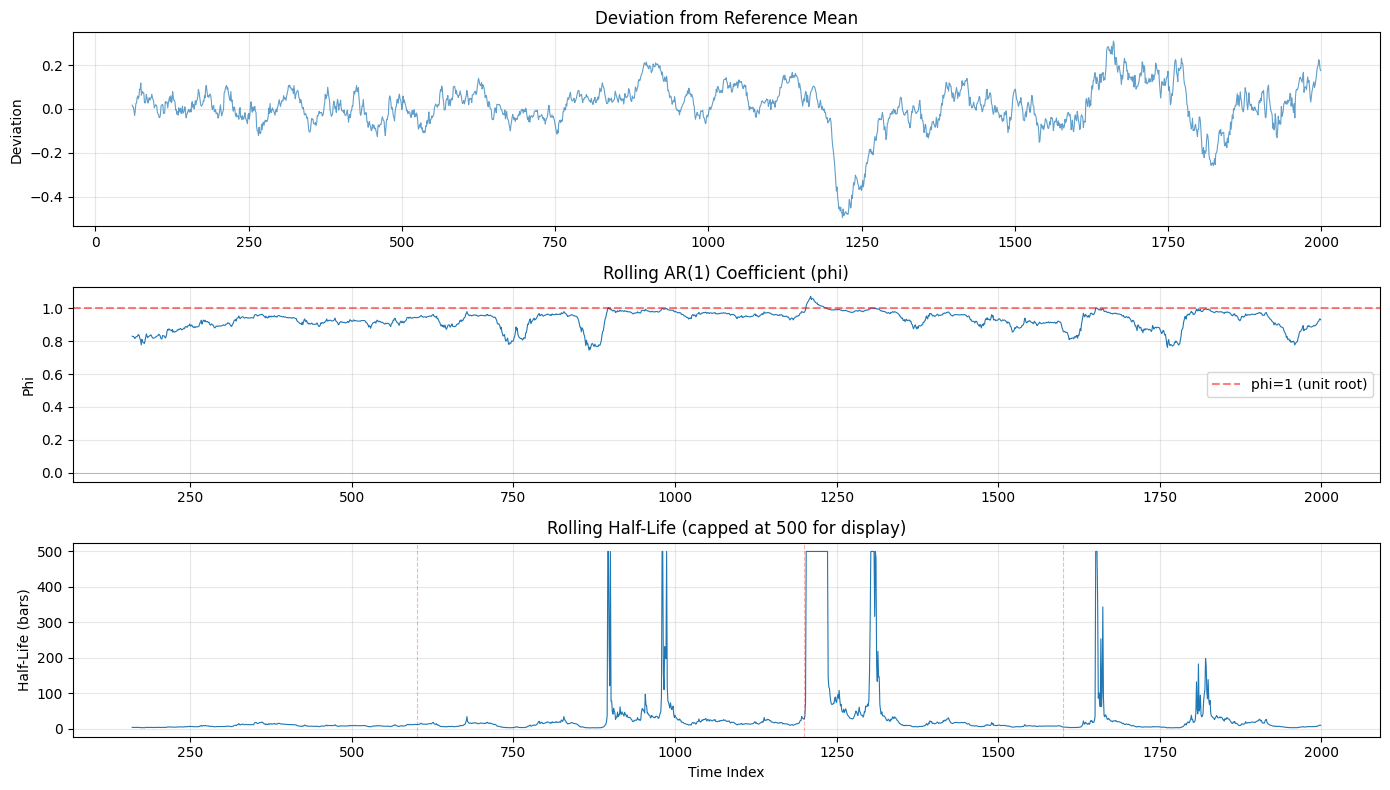


DIAGNOSTICS SAVED: diagnostics.json


In [9]:

print("\n" + "="*60)
print("REVERSION SPEED DIAGNOSTICS: AR(1) AND HALF-LIFE")
print("="*60)

def rolling_ar1_ols(x, W):
    """
    Estimate rolling AR(1) model: x[k] = c + phi * x[k-1] + eps
    using OLS on window [t-W, t-1].

    Returns phi[t] and half_life[t] for each t >= W.

    Args:
        x: time series array (T,)
        W: estimation window

    Returns:
        phi: array (T,) with AR(1) coefficient
        half_life: array (T,) with half-life in bars
        c: array (T,) with intercept
    """
    T = len(x)
    phi = np.full(T, np.nan)
    half_life = np.full(T, np.nan)
    c = np.full(T, np.nan)

    for t in range(W + 1, T):  # Need W+1 for lagged regression
        # Window: [t-W, t-1]
        window = x[t-W:t]

        # Create lagged variables
        y = window[1:]   # x[k]
        X_lag = window[:-1]  # x[k-1]

        n = len(y)
        if n < 2:
            continue

        # OLS: y = c + phi * X_lag
        # Add intercept
        X_mat = np.column_stack([np.ones(n), X_lag])

        # Solve: beta = (X'X)^{-1} X'y
        try:
            XtX = X_mat.T @ X_mat
            Xty = X_mat.T @ y
            beta = np.linalg.solve(XtX, Xty)

            c[t] = beta[0]
            phi[t] = beta[1]

            # Half-life calculation
            # Half-life = log(0.5) / log(|phi|) if 0 < |phi| < 1
            if 0 < abs(phi[t]) < 1:
                half_life[t] = math.log(0.5) / math.log(abs(phi[t]))
            elif abs(phi[t]) >= 1:
                half_life[t] = np.inf
            else:
                half_life[t] = np.nan

        except np.linalg.LinAlgError:
            continue

    return phi, half_life, c


# Estimate AR(1) on deviation series
W_hl = CONFIG['W_hl']
phi_dev, hl_dev, c_dev = rolling_ar1_ols(deviation, W_hl)

# Statistics
valid_phi = phi_dev[~np.isnan(phi_dev)]
valid_hl = hl_dev[~np.isnan(hl_dev) & ~np.isinf(hl_dev)]

print(f"\nAR(1) Diagnostics on Deviation:")
print(f"  Median phi: {np.median(valid_phi):.4f}")
print(f"  Phi 10%/90% quantiles: {np.percentile(valid_phi, [10, 90])}")
print(f"  Fraction |phi| >= 1: {np.mean(np.abs(valid_phi) >= 1):.4f}")

if len(valid_hl) > 0:
    print(f"\nHalf-Life Statistics:")
    print(f"  Median: {np.median(valid_hl):.2f} bars")
    print(f"  10%/90% quantiles: {np.percentile(valid_hl, [10, 90])}")
else:
    print("\nNo valid half-life values computed")

# Plot
plt.figure(figsize=(14, 8))

plt.subplot(3, 1, 1)
plt.plot(t_idx, deviation, linewidth=0.8, alpha=0.7)
plt.title('Deviation from Reference Mean')
plt.ylabel('Deviation')
plt.grid(alpha=0.3)

plt.subplot(3, 1, 2)
plt.plot(t_idx, phi_dev, linewidth=0.8)
plt.axhline(0, color='black', linestyle='-', alpha=0.3, linewidth=0.5)
plt.axhline(1, color='red', linestyle='--', alpha=0.5, label='phi=1 (unit root)')
plt.title('Rolling AR(1) Coefficient (phi)')
plt.ylabel('Phi')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(3, 1, 3)
# Cap half-life for plotting
hl_plot = np.copy(hl_dev)
hl_plot[hl_plot > 500] = 500  # Cap at 500 for visualization
plt.plot(t_idx, hl_plot, linewidth=0.8)
for rc in meta_single['regime_changes']:
    plt.axvline(rc, color='red', linestyle='--', alpha=0.3, linewidth=0.8)
plt.title('Rolling Half-Life (capped at 500 for display)')
plt.xlabel('Time Index')
plt.ylabel('Half-Life (bars)')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('ar1_halflife_diagnostics.png', dpi=100)
plt.show()

# Save diagnostics
diagnostics = {
    "single_asset_deviation": {
        "ar1_phi_median": float(np.median(valid_phi)) if len(valid_phi) > 0 else None,
        "ar1_phi_10pct": float(np.percentile(valid_phi, 10)) if len(valid_phi) > 0 else None,
        "ar1_phi_90pct": float(np.percentile(valid_phi, 90)) if len(valid_phi) > 0 else None,
        "fraction_phi_gte_1": float(np.mean(np.abs(valid_phi) >= 1)) if len(valid_phi) > 0 else None,
        "halflife_median": float(np.median(valid_hl)) if len(valid_hl) > 0 else None,
        "halflife_10pct": float(np.percentile(valid_hl, 10)) if len(valid_hl) > 0 else None,
        "halflife_90pct": float(np.percentile(valid_hl, 90)) if len(valid_hl) > 0 else None
    },
    "z_score_tail_stats": {
        "1pct": float(z_percentiles[0]),
        "5pct": float(z_percentiles[1]),
        "25pct": float(z_percentiles[2]),
        "50pct": float(z_percentiles[3]),
        "75pct": float(z_percentiles[4]),
        "95pct": float(z_percentiles[5]),
        "99pct": float(z_percentiles[6])
    }
}

with open('diagnostics.json', 'w') as f:
    json.dump(diagnostics, f, indent=2)

print("\nDIAGNOSTICS SAVED: diagnostics.json")


##9.PAIRS CONSTTRUCTION

###9.1.OVERVIEW


**Why Pairs Trading?**

Single-asset mean reversion bets that a price returns to its own historical average. Pairs trading is more sophisticated: we bet on the relative relationship between two assets returning to normal. This is market-neutral—we're long one asset and short another, so broad market moves cancel out. We profit purely from the spread between them converging, regardless of whether markets rise or fall.

**Three Spread Definitions**

We construct three spread variants to compare approaches. The log spread (S1 = log(P_A) - log(P_B)) treats both assets equally, assuming a 1:1 relationship. This works if both assets move in lockstep. The log ratio is mathematically identical—just a different notation. But what if Asset A is twice as volatile as Asset B? A 1:1 hedge is wrong.

**Dynamic Hedge Ratios**

The residual spread (S3) uses rolling OLS regression to estimate the optimal hedge ratio (beta): how many units of B should we short for each unit of A we're long? We regress X_A on X_B in a rolling window, estimating alpha (intercept) and beta (slope). The spread becomes the regression residual: S3 = X_A - (alpha + beta × X_B). This adapts to changing relationships—if the correlation strengthens or weakens, beta adjusts.

**Causality in Beta Estimation**

Critical implementation detail: beta[t] uses only data from [t-W, t-1], not including time t. When we hedge at time t, we use yesterday's estimated beta. We verify this with explicit assertions, recomputing beta manually at random time points. The plots show beta evolution over time, revealing the relationship break we engineered. When beta shifts dramatically at the breakpoint, the residual spread adapts while the simple log spread fails to account for the changed relationship.


###9.2.CODE AND IMPLEMENTATION


PAIRS CONSTRUCTION: SPREAD TYPES

Causality Assertion Check (Beta Estimation):
  t=120: beta=0.933454, expected=0.933454 ✓
  t=220: beta=1.092183, expected=1.092183 ✓
  t=620: beta=0.850714, expected=0.850714 ✓
  t=1900: beta=1.509396, expected=1.509396 ✓


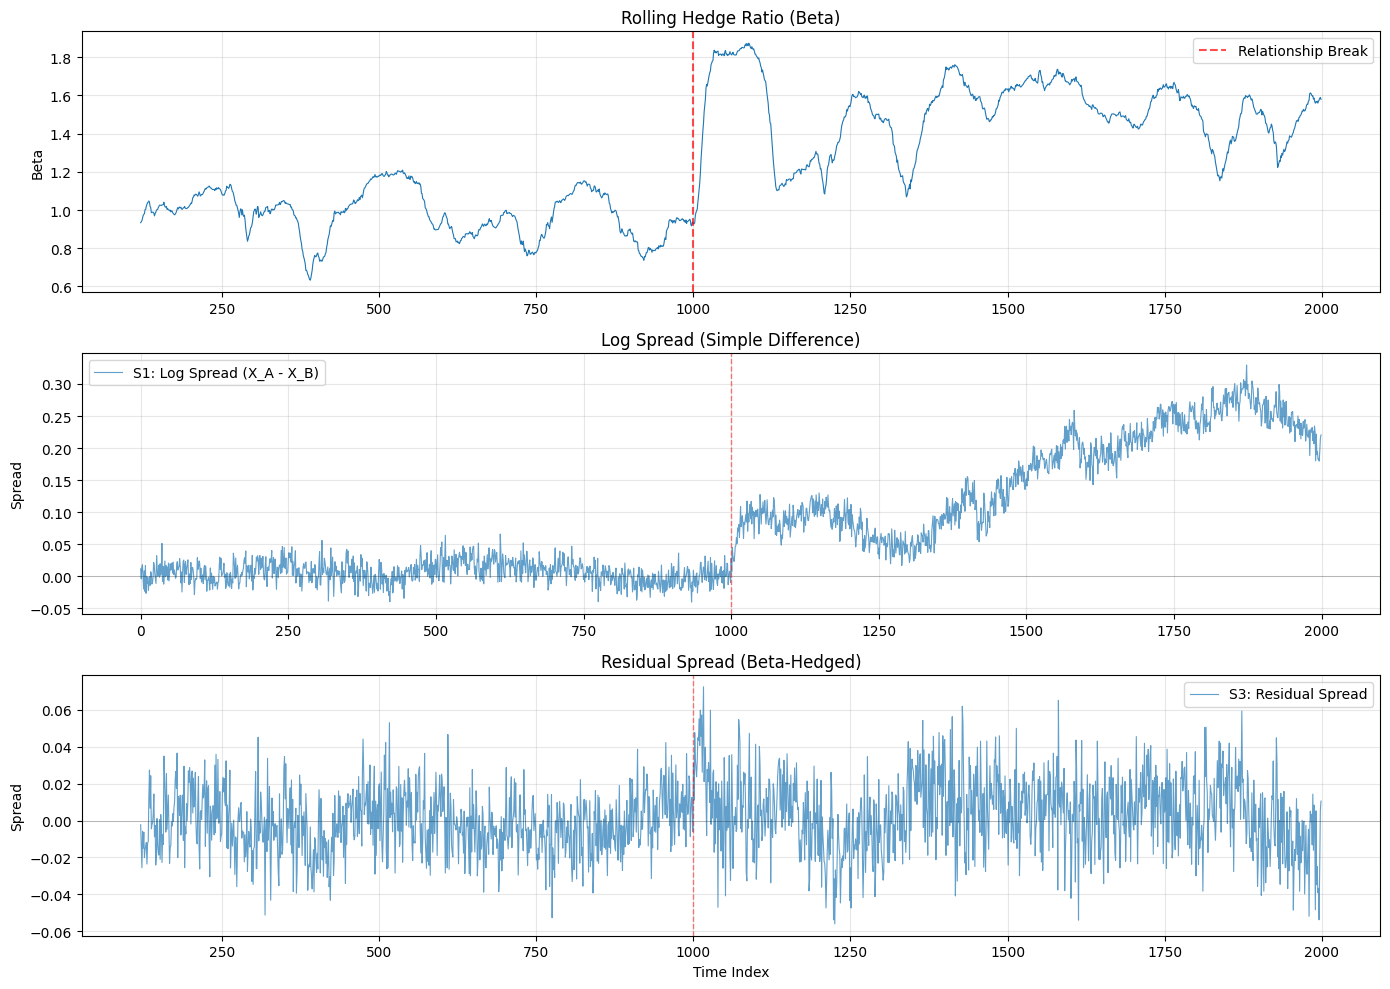


Spread Statistics:
  S1 (log spread) std: 0.094700
  S3 (residual) std: 0.019247
  Beta median: 1.190149
  Beta 10%/90% quantiles: [0.87642476 1.66961799]


In [10]:

print("\n" + "="*60)
print("PAIRS CONSTRUCTION: SPREAD TYPES")
print("="*60)

def rolling_ols_hedge_ratio(x_a, x_b, W):
    """
    Estimate rolling hedge ratio via OLS: x_a = alpha + beta * x_b
    using window [t-W, t-1].

    Returns:
        alpha: array (T,)
        beta: array (T,)
    """
    T = len(x_a)
    alpha = np.full(T, np.nan)
    beta = np.full(T, np.nan)

    for t in range(W, T):
        # Use data [t-W, t-1] (strictly lagged)
        y = x_a[t-W:t]
        x = x_b[t-W:t]

        n = len(y)
        if n < 2:
            continue

        # OLS with intercept
        X_mat = np.column_stack([np.ones(n), x])

        try:
            XtX = X_mat.T @ X_mat
            Xty = X_mat.T @ y
            params = np.linalg.solve(XtX, Xty)

            alpha[t] = params[0]
            beta[t] = params[1]
        except np.linalg.LinAlgError:
            continue

    return alpha, beta


# Spread 1: Log spread (simple difference)
S1 = X_A - X_B

# Spread 2: Same as S1 (log ratio = log difference)
S2 = np.log(P_A / P_B)  # Equivalent to X_A - X_B

# Spread 3: Residual spread with rolling hedge ratio
W_beta = CONFIG['W_beta_est']
alpha_pair, beta_pair = rolling_ols_hedge_ratio(X_A, X_B, W_beta)

# Compute residual spread
S3 = np.full(n_steps, np.nan)
for t in range(W_beta, n_steps):
    if not np.isnan(beta_pair[t]):
        S3[t] = X_A[t] - (alpha_pair[t] + beta_pair[t] * X_B[t])

# Causality assertion: verify beta uses only past data
print("\nCausality Assertion Check (Beta Estimation):")
check_times = [W_beta, W_beta + 100, W_beta + 500, n_steps - 100]
for t in check_times:
    if t < len(X_A) and not np.isnan(beta_pair[t]):
        # Re-compute beta for window [t-W_beta, t-1]
        y_check = X_A[t-W_beta:t]
        x_check = X_B[t-W_beta:t]
        X_mat_check = np.column_stack([np.ones(len(y_check)), x_check])
        XtX_check = X_mat_check.T @ X_mat_check
        Xty_check = X_mat_check.T @ y_check
        params_check = np.linalg.solve(XtX_check, Xty_check)
        beta_check = params_check[1]

        assert abs(beta_pair[t] - beta_check) < 1e-8, f"Causality violation at t={t}"
        print(f"  t={t}: beta={beta_pair[t]:.6f}, expected={beta_check:.6f} ✓")

# Plot
plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
plt.plot(t_idx, beta_pair, linewidth=0.8)
plt.axvline(break_point, color='red', linestyle='--', alpha=0.7, linewidth=1.5, label='Relationship Break')
plt.title('Rolling Hedge Ratio (Beta)')
plt.ylabel('Beta')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(3, 1, 2)
plt.plot(t_idx, S1, linewidth=0.8, alpha=0.7, label='S1: Log Spread (X_A - X_B)')
plt.axhline(0, color='black', linestyle='-', alpha=0.3, linewidth=0.5)
plt.axvline(break_point, color='red', linestyle='--', alpha=0.5, linewidth=1.0)
plt.title('Log Spread (Simple Difference)')
plt.ylabel('Spread')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(3, 1, 3)
plt.plot(t_idx, S3, linewidth=0.8, alpha=0.7, label='S3: Residual Spread')
plt.axhline(0, color='black', linestyle='-', alpha=0.3, linewidth=0.5)
plt.axvline(break_point, color='red', linestyle='--', alpha=0.5, linewidth=1.0)
plt.title('Residual Spread (Beta-Hedged)')
plt.xlabel('Time Index')
plt.ylabel('Spread')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('spread_types.png', dpi=100)
plt.show()

print(f"\nSpread Statistics:")
print(f"  S1 (log spread) std: {np.nanstd(S1):.6f}")
print(f"  S3 (residual) std: {np.nanstd(S3):.6f}")
print(f"  Beta median: {np.nanmedian(beta_pair):.6f}")
print(f"  Beta 10%/90% quantiles: {np.nanpercentile(beta_pair, [10, 90])}")



##10.PAIR SELECTION

###10.1.OVERVIEW

**The Universe Problem**

In real trading, you face hundreds or thousands of potential pairs. How do you choose? The naive approach: screen all pairs on historical correlation, pick the top performers, trade them. This is a recipe for disaster through data mining. With enough pairs tested, some will show spectacular historical correlation purely by chance—but these "best" pairs often perform worst out-of-sample because their past performance was luck, not economics.

**Similarity Isn't Stability**

We generate a synthetic universe of 10 assets driven by 3 common factors. Only assets 0-1 and 2-3 share true stable relationships (same factor exposure). The rest are noise. We screen pairs using correlation on a training window—a common industry practice. The danger: high correlation doesn't distinguish between genuine economic linkages and spurious statistical relationships. Two unrelated stocks might correlate highly for a year, then diverge completely.

**Search Budget as Discipline**

We impose a maximum number of pairs to test (max_pairs_tested). This simulates a real constraint: you can't backtest infinite combinations. But even with limits, the best-looking pair from your search is likely overfit—you've selected the luckiest outcome from your sample. The pair_selection_log records every pair tested, the metric used, and timestamps, creating an audit trail of your search process.

**Economic Reasoning Over Statistics**

The markdown warning emphasizes: correlation is a starting point, not a conclusion. True pairs share economic drivers—two airlines affected by fuel prices, two retailers competing in the same market, two bonds with similar duration. The relationship break in our data demonstrates this: when factor loadings change (simulating a business model shift), historically correlated pairs can fail catastrophically. Always ask: why should these assets move together, not just: did they move together in the past?

###10.2.CODE AND IMPLEMENTATION

In [12]:
print("\n" + "="*60)
print("PAIR SELECTION DEMO: UNIVERSE SCREENING")
print("="*60)

def generate_synthetic_universe(n_assets, n_steps, n_factors, seed=None):
    """
    Generate synthetic universe of assets from factor model.

    X_i = sum_k (beta_ik * F_k) + idio_i

    Only a few asset pairs share strong stable relationships.

    Returns:
        prices: dict {asset_id: price_array}
        log_prices: dict {asset_id: log_price_array}
        metadata: dict with factor loadings
    """
    if seed is not None:
        np.random.seed(seed)

    # Generate factors (random walks)
    factors = np.zeros((n_steps, n_factors))
    for k in range(n_factors):
        for t in range(1, n_steps):
            factors[t, k] = factors[t-1, k] + 0.01 * np.random.randn()

    # Generate asset loadings
    # First 2 assets: strong loading on factor 0 (true pair)
    # Next 2 assets: strong loading on factor 1 (another true pair)
    # Rest: mixed loadings (noise)

    loadings = np.random.randn(n_assets, n_factors) * 0.1
    loadings[0, 0] = 0.9  # Asset 0: strong on F0
    loadings[1, 0] = 0.85 # Asset 1: strong on F0 (pair with 0)
    loadings[2, 1] = 0.8  # Asset 2: strong on F1
    loadings[3, 1] = 0.75 # Asset 3: strong on F1 (pair with 2)

    prices = {}
    log_prices = {}

    for i in range(n_assets):
        X = np.zeros(n_steps)
        for t in range(n_steps):
            X[t] = np.dot(loadings[i, :], factors[t, :]) + 0.02 * np.random.randn()

        log_prices[f'asset_{i}'] = X
        prices[f'asset_{i}'] = np.exp(X)

    metadata = {
        'n_factors': n_factors,
        'loadings': loadings.tolist(),
        'true_pairs': [(0, 1), (2, 3)]  # Known stable pairs
    }

    return prices, log_prices, metadata


# Generate universe
n_assets = 10
n_factors = 3
prices_univ, log_prices_univ, meta_univ = generate_synthetic_universe(
    n_assets, n_steps, n_factors, seed=SEED+2
)

# Pair selection: screen on correlation (training window)
train_end = 1000  # Use first 1000 bars for screening
max_pairs_tested = CONFIG['max_pairs_tested']

def compute_correlation(x, y, start, end):
    """Compute correlation between two series on a window."""
    x_w = x[start:end]
    y_w = y[start:end]

    # Remove NaN
    valid = ~(np.isnan(x_w) | np.isnan(y_w))
    x_w = x_w[valid]
    y_w = y_w[valid]

    if len(x_w) < 2:
        return np.nan

    return np.corrcoef(x_w, y_w)[0, 1]


# Screen all pairs
pair_candidates = []
asset_ids = list(log_prices_univ.keys())

for i in range(len(asset_ids)):
    for j in range(i+1, len(asset_ids)):
        id_a = asset_ids[i]
        id_b = asset_ids[j]

        # Compute returns correlation on training window
        x_a = log_prices_univ[id_a]
        x_b = log_prices_univ[id_b]

        corr = compute_correlation(x_a, x_b, 0, train_end)

        pair_candidates.append({
            'asset_a': id_a,
            'asset_b': id_b,
            'correlation': float(corr) if not np.isnan(corr) else None,
            'train_window': [0, train_end]
        })

        if len(pair_candidates) >= max_pairs_tested:
            break
    if len(pair_candidates) >= max_pairs_tested:
        break

# Sort by absolute correlation
pair_candidates_valid = [p for p in pair_candidates if p['correlation'] is not None]
pair_candidates_sorted = sorted(pair_candidates_valid, key=lambda x: abs(x['correlation']), reverse=True)

# Select top pair
if len(pair_candidates_sorted) > 0:
    selected_pair = pair_candidates_sorted[0]
    print(f"\nPair Selection Results:")
    print(f"  Pairs tested: {len(pair_candidates)}")
    print(f"  Selected pair: {selected_pair['asset_a']} - {selected_pair['asset_b']}")
    print(f"  Training correlation: {selected_pair['correlation']:.4f}")
    print(f"\nTop 5 pairs by |correlation|:")
    for k, p in enumerate(pair_candidates_sorted[:5]):
        print(f"  {k+1}. {p['asset_a']} - {p['asset_b']}: {p['correlation']:.4f}")
else:
    selected_pair = None
    print("No valid pairs found")

# Save pair selection log
pair_selection_log = {
    'universe_size': n_assets,
    'search_budget': max_pairs_tested,
    'train_window': [0, train_end],
    'selection_time': train_end,
    'metric': 'correlation',
    'pairs_tested': pair_candidates,
    'selected_pair': selected_pair
}

with open('pair_selection_log.json', 'w') as f:
    json.dump(pair_selection_log, f, indent=2)

print("\nPAIR SELECTION LOG SAVED: pair_selection_log.json")

# Warning about overfitting
print("\n" + "="*60)
print("WARNING: OVER-SEARCH TRAP")
print("="*60)
print(textwrap.fill(
    "Selecting pairs based solely on historical correlation can lead to overfitting. "
    "The best-looking correlation may not persist out-of-sample, especially after "
    "relationship breaks. Economic reasoning (common factors, supply chains, substitutes) "
    "should guide pair selection, not just statistical similarity. "
    "Search budget limits help but do not eliminate this risk.",
    width=70
))




PAIR SELECTION DEMO: UNIVERSE SCREENING

Pair Selection Results:
  Pairs tested: 45
  Selected pair: asset_0 - asset_1
  Training correlation: 0.9652

Top 5 pairs by |correlation|:
  1. asset_0 - asset_1: 0.9652
  2. asset_1 - asset_5: 0.6505
  3. asset_0 - asset_5: 0.6279
  4. asset_1 - asset_7: -0.6079
  5. asset_0 - asset_6: -0.6047

PAIR SELECTION LOG SAVED: pair_selection_log.json

Selecting pairs based solely on historical correlation can lead to
overfitting. The best-looking correlation may not persist out-of-
sample, especially after relationship breaks. Economic reasoning
(common factors, supply chains, substitutes) should guide pair
selection, not just statistical similarity. Search budget limits help
but do not eliminate this risk.


##11.PAIRS TRADING STRATEGY

###11.1.OVERVIEW



**Trading the Spread, Not the Assets**

We now trade the pairs spread using the same mean reversion logic from single assets, but with a crucial difference: our position is split across two securities. When the spread z-score reaches +2.0 (spread too wide), we short the spread: sell Asset A and buy Asset B, expecting convergence. When z-score hits -2.0 (spread too tight), we long the spread: buy A and sell B. The hysteresis bands and stops from Strategy 2 apply identically.

**Dynamic Hedging with Beta**

Position sizing must respect the hedge ratio. If beta = 0.8, then for each $1 long in Asset A, we should be $0.80 short in Asset B to maintain market neutrality. As beta evolves in our rolling window, our hedge ratio adjusts—we're not locked into a static relationship. However, we impose an exposure cap (p_max) to prevent leverage from exploding when beta estimates become extreme or unstable.

**PnL Across Two Legs**

Computing profit requires tracking both positions. At each time step, PnL = position_A × return_A + position_B × return_B. Since we're hedged, the returns partially offset—broad market moves cancel out while spread convergence generates profit. This is the essence of market-neutral trading: you're immune to whether the overall market rises or falls, caring only about relative movements.

**Performance After the Break**

The equity curve reveals strategy behavior across our engineered relationship break. Before the breakpoint, when the pair relationship is stable, mean reversion works well—spreads that widen do narrow again. After the break, when factor loadings shift, the strategy faces harder conditions. The diagnostic metrics (stop frequencies, holding periods, turnover) quantify this degradation. We save complete results to NPZ files: positions, spreads, z-scores, equity curves—everything needed for post-trade analysis and regulatory audit trails.

###11.2.CODE AND IMPLEMENTATION


PAIRS TRADING STRATEGY

Pairs Strategy Performance:
  Total Return: 2.978194
  Max Drawdown: -0.085833
  Position Changes: 361
  Number of Trades: 85

Exit Reason Frequencies:
  Normal Exit: 85
  Z-Stop: 0
  Time-Stop: 0


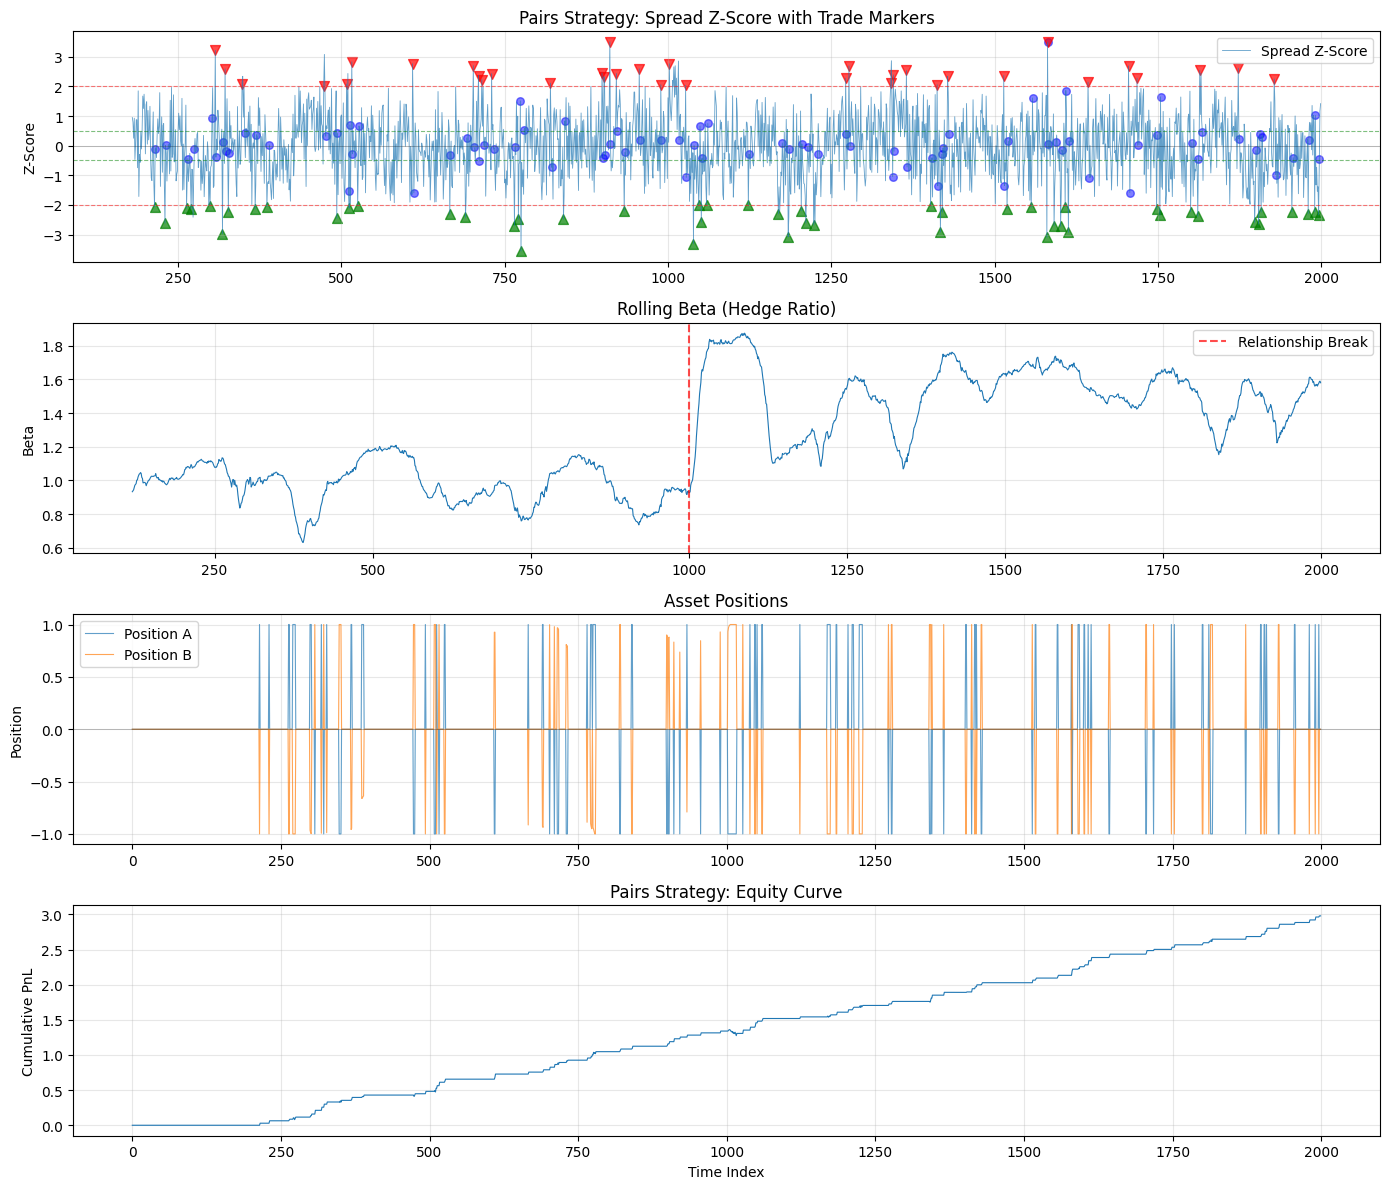


RESULTS SAVED:
  results_single_asset.npz
  results_pairs.npz


In [14]:
print("\n" + "="*60)
print("PAIRS TRADING STRATEGY")
print("="*60)

# Use the synthetic pair A and B (not from universe, for clarity)
# Choose spread type: S3 (residual spread with rolling beta)
spread_trade = S3.copy()

# Compute spread z-score
mu_spread = rolling_mean_lag(spread_trade, W_ref)
sigma_spread = rolling_std_lag(spread_trade, W_ref)
z_spread = zscore_from_ref(spread_trade, mu_spread, sigma_spread, eps=1e-8)

# Trading strategy on spread z-score
# If z >= z_in: short spread (short A, long B)
# If z <= -z_in: long spread (long A, short B)

p_spread_raw, state_log_spread, trade_log_spread = strategy_hysteresis_with_stops(
    z_spread, z_in, z_out, z_stop, H_max, cooldown
)

# Convert spread position to asset positions
# Spread = X_A - beta * X_B
# Long spread => long A, short B
# Short spread => short A, long B

# Position sizing with exposure cap
p_max = CONFIG['p_max']
p_A = np.zeros(n_steps)
p_B = np.zeros(n_steps)

for t in range(n_steps):
    if p_spread_raw[t] == 1:  # Long spread
        p_A[t] = p_max
        if not np.isnan(beta_pair[t]):
            p_B[t] = -p_max * beta_pair[t]
        else:
            p_B[t] = -p_max  # Fallback
    elif p_spread_raw[t] == -1:  # Short spread
        p_A[t] = -p_max
        if not np.isnan(beta_pair[t]):
            p_B[t] = p_max * beta_pair[t]
        else:
            p_B[t] = p_max  # Fallback

    # Cap exposures
    p_A[t] = np.clip(p_A[t], -p_max, p_max)
    p_B[t] = np.clip(p_B[t], -p_max, p_max)

# Compute PnL
r_A = np.diff(X_A, prepend=X_A[0])
r_A[0] = 0.0
r_B = np.diff(X_B, prepend=X_B[0])
r_B[0] = 0.0

pnl_pairs = np.zeros(n_steps)
for t in range(n_steps - 1):
    pnl_pairs[t+1] = p_A[t] * (X_A[t+1] - X_A[t]) + p_B[t] * (X_B[t+1] - X_B[t])

equity_pairs = np.cumsum(pnl_pairs)

# Performance
total_return_pairs = equity_pairs[-1]
max_dd_pairs = compute_max_drawdown(equity_pairs)
turnover_pairs = np.sum(np.abs(np.diff(p_A)) > 0) + np.sum(np.abs(np.diff(p_B)) > 0)

# Trade stats
holding_periods_pairs = [t['holding_period'] for t in trade_log_spread]
z_stop_count_pairs = sum(1 for t in trade_log_spread if t['exit_reason'] == 'z_stop')
time_stop_count_pairs = sum(1 for t in trade_log_spread if t['exit_reason'] == 'time_stop')
normal_exit_count_pairs = sum(1 for t in trade_log_spread if t['exit_reason'] == 'normal_exit')

print(f"\nPairs Strategy Performance:")
print(f"  Total Return: {total_return_pairs:.6f}")
print(f"  Max Drawdown: {max_dd_pairs:.6f}")
print(f"  Position Changes: {turnover_pairs}")
print(f"  Number of Trades: {len(trade_log_spread)}")
print(f"\nExit Reason Frequencies:")
print(f"  Normal Exit: {normal_exit_count_pairs}")
print(f"  Z-Stop: {z_stop_count_pairs}")
print(f"  Time-Stop: {time_stop_count_pairs}")

# Plot
plt.figure(figsize=(14, 12))

plt.subplot(4, 1, 1)
plt.plot(t_idx, z_spread, linewidth=0.6, alpha=0.7, label='Spread Z-Score')
plt.axhline(0, color='black', linestyle='-', alpha=0.3, linewidth=0.5)
plt.axhline(z_in, color='red', linestyle='--', alpha=0.5, linewidth=0.8)
plt.axhline(-z_in, color='red', linestyle='--', alpha=0.5, linewidth=0.8)
plt.axhline(z_out, color='green', linestyle='--', alpha=0.5, linewidth=0.8)
plt.axhline(-z_out, color='green', linestyle='--', alpha=0.5, linewidth=0.8)

# Mark trades
for t, state, reason in state_log_spread:
    if 'enter_long' in reason:
        plt.scatter(t, z_spread[t], color='green', marker='^', s=50, alpha=0.7)
    elif 'enter_short' in reason:
        plt.scatter(t, z_spread[t], color='red', marker='v', s=50, alpha=0.7)
    elif 'exit' in reason or 'stop' in reason:
        plt.scatter(t, z_spread[t], color='blue', marker='o', s=30, alpha=0.5)

plt.title('Pairs Strategy: Spread Z-Score with Trade Markers')
plt.ylabel('Z-Score')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(4, 1, 2)
plt.plot(t_idx, beta_pair, linewidth=0.8)
plt.axvline(break_point, color='red', linestyle='--', alpha=0.7, linewidth=1.5, label='Relationship Break')
plt.title('Rolling Beta (Hedge Ratio)')
plt.ylabel('Beta')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(4, 1, 3)
plt.plot(t_idx, p_A, linewidth=0.8, label='Position A', alpha=0.7)
plt.plot(t_idx, p_B, linewidth=0.8, label='Position B', alpha=0.7)
plt.axhline(0, color='black', linestyle='-', alpha=0.3, linewidth=0.5)
plt.title('Asset Positions')
plt.ylabel('Position')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(4, 1, 4)
plt.plot(t_idx, equity_pairs, linewidth=0.8)
plt.title('Pairs Strategy: Equity Curve')
plt.xlabel('Time Index')
plt.ylabel('Cumulative PnL')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('pairs_strategy.png', dpi=100)
plt.show()

# Save results
np.savez('results_single_asset.npz',
         dates_idx=t_idx,
         price=P_single,
         z=z_single,
         position=p_s2,
         pnl=pnl_s2,
         equity=equity_s2)

np.savez('results_pairs.npz',
         dates_idx=t_idx,
         priceA=P_A,
         priceB=P_B,
         beta=beta_pair,
         spread=spread_trade,
         zS=z_spread,
         posA=p_A,
         posB=p_B,
         pnl=pnl_pairs,
         equity=equity_pairs)

print("\nRESULTS SAVED:")
print("  results_single_asset.npz")
print("  results_pairs.npz")


##12.DIAGNOSTIC PACK

###12.1.OVERVIEW



**Beyond Simple Returns**

A profitable backtest isn't enough. Professional risk management demands understanding why a strategy works, when it works, and whether it's robust to reasonable perturbations. This cell creates a comprehensive diagnostic report that would satisfy a risk committee or regulatory review—metrics that reveal structural health beyond surface-level performance.

**Spread Reversion Speed**

We apply the same AR(1) half-life analysis from Cell 8 to the pairs spread itself. Does the spread revert quickly (half-life of 10-20 bars) or slowly (100+ bars)? If the spread's half-life is much longer than your average holding period, you're exiting positions before reversion completes—leaving money on the table or taking losses prematurely. Tracking how half-life changes over time reveals when pair relationships strengthen or weaken.

**Tail Risk and Extreme Events**

The z-score percentiles (1%, 5%, 95%, 99%) characterize the spread's tail behavior. Fat tails mean extreme spread widening happens more often than normal distributions predict—your position sizing and stop placement must account for this. If your 99th percentile z-score is 4.5 but your z-stop is at 3.5, you're getting stopped out frequently by normal market volatility, not genuine regime breaks.

**Sensitivity and Subsample Tests**

We perturb the beta estimation window by ±20% and measure how much the hedge ratio changes. Large sensitivity suggests the relationship is unstable—small parameter changes produce big strategy differences. The subsample analysis splits performance into first-half versus second-half returns, checking if profitability is concentrated in one period (warning sign) or consistent throughout. All diagnostics save to JSON, creating a permanent record of due diligence that demonstrates you understood your strategy's risks before deploying capital.

###12.2.CODE AND IMPLEMENTATION

In [16]:
print("\n" + "="*60)
print("DIAGNOSTICS PACK SUMMARY")
print("="*60)

# Half-life for spread
phi_spread, hl_spread, c_spread = rolling_ar1_ols(spread_trade, W_hl)

valid_phi_spread = phi_spread[~np.isnan(phi_spread)]
valid_hl_spread = hl_spread[~np.isnan(hl_spread) & ~np.isinf(hl_spread)]

print(f"\nSpread AR(1) Diagnostics:")
if len(valid_phi_spread) > 0:
    print(f"  Median phi: {np.median(valid_phi_spread):.4f}")
    print(f"  Phi 10%/90% quantiles: {np.percentile(valid_phi_spread, [10, 90])}")
    print(f"  Fraction |phi| >= 1: {np.mean(np.abs(valid_phi_spread) >= 1):.4f}")

if len(valid_hl_spread) > 0:
    print(f"\nSpread Half-Life:")
    print(f"  Median: {np.median(valid_hl_spread):.2f} bars")
    print(f"  10%/90% quantiles: {np.percentile(valid_hl_spread, [10, 90])}")

# Spread tail stats
valid_zS = z_spread[~np.isnan(z_spread)]
zS_percentiles = np.percentile(valid_zS, [1, 5, 25, 50, 75, 95, 99])

print(f"\nSpread Z-Score Tail Statistics:")
print(f"  1%:  {zS_percentiles[0]:.4f}")
print(f"  5%:  {zS_percentiles[1]:.4f}")
print(f"  25%: {zS_percentiles[2]:.4f}")
print(f"  50%: {zS_percentiles[3]:.4f}")
print(f"  75%: {zS_percentiles[4]:.4f}")
print(f"  95%: {zS_percentiles[5]:.4f}")
print(f"  99%: {zS_percentiles[6]:.4f}")

# Sensitivity check: W_beta perturbation
print(f"\nSensitivity Check: Beta Window Perturbation")
W_beta_low = int(W_beta * 0.8)
W_beta_high = int(W_beta * 1.2)

alpha_low, beta_low = rolling_ols_hedge_ratio(X_A, X_B, W_beta_low)
alpha_high, beta_high = rolling_ols_hedge_ratio(X_A, X_B, W_beta_high)

beta_diff_low = np.nanmean(np.abs(beta_pair - beta_low))
beta_diff_high = np.nanmean(np.abs(beta_pair - beta_high))

print(f"  W_beta = {W_beta_low} (80%): Mean |diff| = {beta_diff_low:.6f}")
print(f"  W_beta = {W_beta_high} (120%): Mean |diff| = {beta_diff_high:.6f}")

# Subsample performance
half_point = n_steps // 2
equity_first_half = equity_pairs[half_point]
equity_second_half = equity_pairs[-1] - equity_pairs[half_point]

print(f"\nSubsample Performance:")
print(f"  First half return: {equity_first_half:.6f}")
print(f"  Second half return: {equity_second_half:.6f}")

# Update diagnostics
diagnostics["spread_diagnostics"] = {
    "ar1_phi_median": float(np.median(valid_phi_spread)) if len(valid_phi_spread) > 0 else None,
    "ar1_phi_10pct": float(np.percentile(valid_phi_spread, 10)) if len(valid_phi_spread) > 0 else None,
    "ar1_phi_90pct": float(np.percentile(valid_phi_spread, 90)) if len(valid_phi_spread) > 0 else None,
    "fraction_phi_gte_1": float(np.mean(np.abs(valid_phi_spread) >= 1)) if len(valid_phi_spread) > 0 else None,
    "halflife_median": float(np.median(valid_hl_spread)) if len(valid_hl_spread) > 0 else None,
    "halflife_10pct": float(np.percentile(valid_hl_spread, 10)) if len(valid_hl_spread) > 0 else None,
    "halflife_90pct": float(np.percentile(valid_hl_spread, 90)) if len(valid_hl_spread) > 0 else None,
    "z_score_tail": {
        "1pct": float(zS_percentiles[0]),
        "5pct": float(zS_percentiles[1]),
        "25pct": float(zS_percentiles[2]),
        "50pct": float(zS_percentiles[3]),
        "75pct": float(zS_percentiles[4]),
        "95pct": float(zS_percentiles[5]),
        "99pct": float(zS_percentiles[6])
    }
}

diagnostics["sensitivity_checks"] = {
    "beta_window_perturbation": {
        "W_beta_nominal": W_beta,
        "W_beta_low": W_beta_low,
        "W_beta_high": W_beta_high,
        "mean_abs_diff_low": float(beta_diff_low),
        "mean_abs_diff_high": float(beta_diff_high)
    },
    "subsample_performance": {
        "first_half_return": float(equity_first_half),
        "second_half_return": float(equity_second_half)
    }
}

with open('diagnostics.json', 'w') as f:
    json.dump(diagnostics, f, indent=2)

print("\nDIAGNOSTICS UPDATED: diagnostics.json")



DIAGNOSTICS PACK SUMMARY

Spread AR(1) Diagnostics:
  Median phi: 0.1341
  Phi 10%/90% quantiles: [-0.02927807  0.33011206]
  Fraction |phi| >= 1: 0.0000

Spread Half-Life:
  Median: 0.35 bars
  10%/90% quantiles: [0.1847649 0.6254018]

Spread Z-Score Tail Statistics:
  1%:  -2.4739
  5%:  -1.7442
  25%: -0.7094
  50%: -0.0077
  75%: 0.7088
  95%: 1.7188
  99%: 2.5215

Sensitivity Check: Beta Window Perturbation
  W_beta = 96 (80%): Mean |diff| = 0.080371
  W_beta = 144 (120%): Mean |diff| = 0.063824

Subsample Performance:
  First half return: 1.339814
  Second half return: 1.638380

DIAGNOSTICS UPDATED: diagnostics.json


##13.GOVERNANCE ARTIFACTS

###13.1.OVERVIEW


**Why Governance Matters**

In institutional settings, you must prove what you did, when you did it, and why. Regulators demand audit trails. Risk managers need to reproduce results. Future you (six months later) needs to understand past decisions. This cell creates a complete documentation package that makes your research reproducible, auditable, and defensible—the difference between professional quant work and undocumented experimentation.

**Lineage: The Data Story**

The lineage.json file traces every transformation from raw data to final signals. It documents: data source (synthetic generator functions with exact parameters), every mathematical operation applied (log transform, rolling windows, z-scores, OLS regression), window sizes used, and the decision-time convention enforced. Anyone reading this file can reconstruct your exact methodology. If a regulator asks "how did you compute this signal," you hand them the lineage file—complete answer.

**The Run Hash: Immutable Identity**

We compute a SHA256 hash over configuration files, manifests, and key result arrays. This cryptographic fingerprint uniquely identifies this exact run. If you change any parameter, any threshold, any window size, the hash changes. This prevents accidental result mixing: you can't confuse results from different parameter sets. It also enables version control—you can match strategies in production back to specific backtest runs by comparing hashes.

**Complete Artifact Inventory**

The cell lists every file created: configs, manifests, logs, diagnostics, results (NPZ), plots (PNG), and the run hash. We verify each file exists, printing a checklist with ✓ or ✗ markers. This inventory is your deliverable package. Whether presenting to a portfolio manager, submitting to compliance, or publishing research, you have everything documented: parameters, logic, results, diagnostics, and governance—institutional-grade work product.

###13.2.CODE AND IMPLEMENTATION

In [17]:

print("\n" + "="*60)
print("GOVERNANCE ARTIFACTS")
print("="*60)

# Lineage
lineage = {
    "data_source": "synthetic",
    "generators": {
        "single_asset": {
            "function": "generate_single_asset_multiregime",
            "regime_params": CONFIG['regime_params'],
            "regime_schedule": meta_single['regime_schedule']
        },
        "pair": {
            "function": "generate_pair_with_break",
            "break_point": break_point,
            "common_factor_weight": CONFIG['regime_params']['pair_common_weight'],
            "idio_sigma": CONFIG['regime_params']['pair_idio_sigma']
        }
    },
    "transforms": [
        {
            "step": "log_price",
            "operation": "np.log(P)"
        },
        {
            "step": "rolling_mean",
            "window": W_ref,
            "lag": True
        },
        {
            "step": "rolling_std",
            "window": W_ref,
            "lag": True
        },
        {
            "step": "z_score",
            "formula": "(x - mu) / (sigma + eps)",
            "eps": 1e-8
        },
        {
            "step": "rolling_ols_beta",
            "window": W_beta,
            "lag": True
        },
        {
            "step": "residual_spread",
            "formula": "X_A - (alpha + beta * X_B)"
        }
    ],
    "window_registry": {
        "W_ref": W_ref,
        "W_vol": CONFIG['W_vol'],
        "W_beta_est": W_beta,
        "W_hl": W_hl
    },
    "decision_time_convention": CONFIG['decision_time_convention']
}

with open('lineage.json', 'w') as f:
    json.dump(lineage, f, indent=2)

# Compute run hash
def compute_run_hash():
    """Compute SHA256 hash of config + manifests + key arrays."""
    hasher = hashlib.sha256()

    # Hash config
    with open('config.json', 'rb') as f:
        hasher.update(f.read())

    # Hash manifests
    with open('strategy_manifest.json', 'rb') as f:
        hasher.update(f.read())

    with open('signal_registry.json', 'rb') as f:
        hasher.update(f.read())

    with open('lineage.json', 'rb') as f:
        hasher.update(f.read())

    # Hash key arrays
    hasher.update(P_single.tobytes())
    hasher.update(z_single.tobytes())
    hasher.update(equity_s2.tobytes())
    hasher.update(equity_pairs.tobytes())

    return hasher.hexdigest()

run_hash = compute_run_hash()

with open('run_hash.txt', 'w') as f:
    f.write(run_hash)

print("\nGOVERNANCE FILES SAVED:")
print("  lineage.json")
print("  run_hash.txt")
print(f"\nRun Hash: {run_hash}")

# Summary of all artifacts
artifacts = [
    'config.json',
    'strategy_manifest.json',
    'signal_registry.json',
    'lineage.json',
    'pair_selection_log.json',
    'diagnostics.json',
    'results_single_asset.npz',
    'results_pairs.npz',
    'run_hash.txt',
    'synthetic_data.png',
    'single_asset_signals.png',
    'strategy1_hysteresis.png',
    'strategy2_with_stops.png',
    'ar1_halflife_diagnostics.png',
    'spread_types.png',
    'pairs_strategy.png'
]

print("\n" + "="*60)
print("ARTIFACT INVENTORY")
print("="*60)
for artifact in artifacts:
    exists = "✓" if os.path.exists(artifact) else "✗"
    print(f"  {exists} {artifact}")



GOVERNANCE ARTIFACTS

GOVERNANCE FILES SAVED:
  lineage.json
  run_hash.txt

Run Hash: 451a96339e518c7c993e9bbf782aec2fbc4b48654127933d47c52d1c75f2f421

ARTIFACT INVENTORY
  ✓ config.json
  ✓ strategy_manifest.json
  ✓ signal_registry.json
  ✓ lineage.json
  ✓ pair_selection_log.json
  ✓ diagnostics.json
  ✓ results_single_asset.npz
  ✓ results_pairs.npz
  ✓ run_hash.txt
  ✓ synthetic_data.png
  ✓ single_asset_signals.png
  ✓ strategy1_hysteresis.png
  ✓ strategy2_with_stops.png
  ✓ ar1_halflife_diagnostics.png
  ✓ spread_types.png
  ✓ pairs_strategy.png


##14.A TRY WITH YFINANCE

###14.1.OVERVIEW


**Institutional-Grade Performance Measurement**

This cell transforms our backtest results into a complete performance report that meets institutional standards. We go far beyond simple profit/loss, implementing the same metrics used by hedge funds, asset managers, and risk committees to evaluate trading strategies rigorously.

**Returns-Based Metrics Suite**

We compute the Sharpe ratio (risk-adjusted returns assuming normal distributions), Sortino ratio (penalizes only downside volatility, not upside), Calmar ratio (return per unit of maximum drawdown), and Omega ratio (probability-weighted gains versus losses). Each metric reveals different aspects of strategy quality. A high Sharpe with low Sortino suggests symmetric volatility; high Calmar indicates drawdown resilience.

**Risk Analytics Beyond Drawdown**

Maximum drawdown is standard, but we add critical detail: duration (how long were you underwater?), recovery time (how long to regain losses?), and current drawdown (are you in a hole right now?). Value at Risk (VaR) and Conditional VaR tell us: "95% of the time, daily losses won't exceed X" and "when losses breach VaR, expect average loss of Y." These quantify tail risk that average volatility misses.

**Trade-Level Forensics**

We dissect individual trades to compute win rate, profit factor (gross wins divided by gross losses), expectancy (average profit per trade), largest win/loss, and holding periods. This reveals whether your edge comes from high win rates with small wins, or low win rates with asymmetric payoffs. The trade PnL plots show if profits come from steady accumulation or a few lucky trades—critical for assessing robustness.

**Regime-Conditional Analysis**

Performance is split by market regime (mean-reverting, trending, high volatility). A strategy might show great overall Sharpe but terrible performance in trending regimes—exactly when you'd deploy it in real markets. This analysis prevents deploying strategies in conditions where they historically failed.

**Rolling Stability Diagnostics**

We compute 252-period rolling Sharpe and 60-period rolling volatility to check temporal stability. Does the strategy maintain edge consistently, or was performance concentrated in one lucky period? The underwater plot visualizes drawdown evolution; return distribution histograms reveal skewness and kurtosis that summary statistics hide.

**Real Data Validation (Optional)**

Finally, we apply the exact same pipeline to real market data (SPY-TLT pair) using yfinance. This validates that our synthetic testing translates to actual securities. The comparison reveals data quality issues, regime differences, and whether theoretical edges survive real market frictions. All metrics save to JSON for audit trails and regulatory compliance.

###14.2.CODE AND IMPLEMENTATION


OPTIONAL: REAL DATA ADAPTER + COMPREHENSIVE PERFORMANCE ANALYTICS

SINGLE ASSET STRATEGY (Strategy 2 with Stops) - PERFORMANCE ANALYTICS

--------------------------------RETURNS METRICS---------------------------------
Total Return:                        0.020252
Annualized Return:                   0.002552
Annualized Volatility:               0.243630
Sharpe Ratio:                          0.0105
Sortino Ratio:                         0.0150
Calmar Ratio:                          0.0019
Omega Ratio:                           1.0024

----------------------------------RISK METRICS----------------------------------
Maximum Drawdown:                   -1.356296
Maximum Drawdown %:                  -1618.74%
Drawdown Duration:                        915 periods
Recovery Time:                   Not Recovered
Current Drawdown:                   -0.998952
VaR (95%):                          -0.026736
CVaR (95%):                         -0.038144
VaR (99%):                          -0.04565

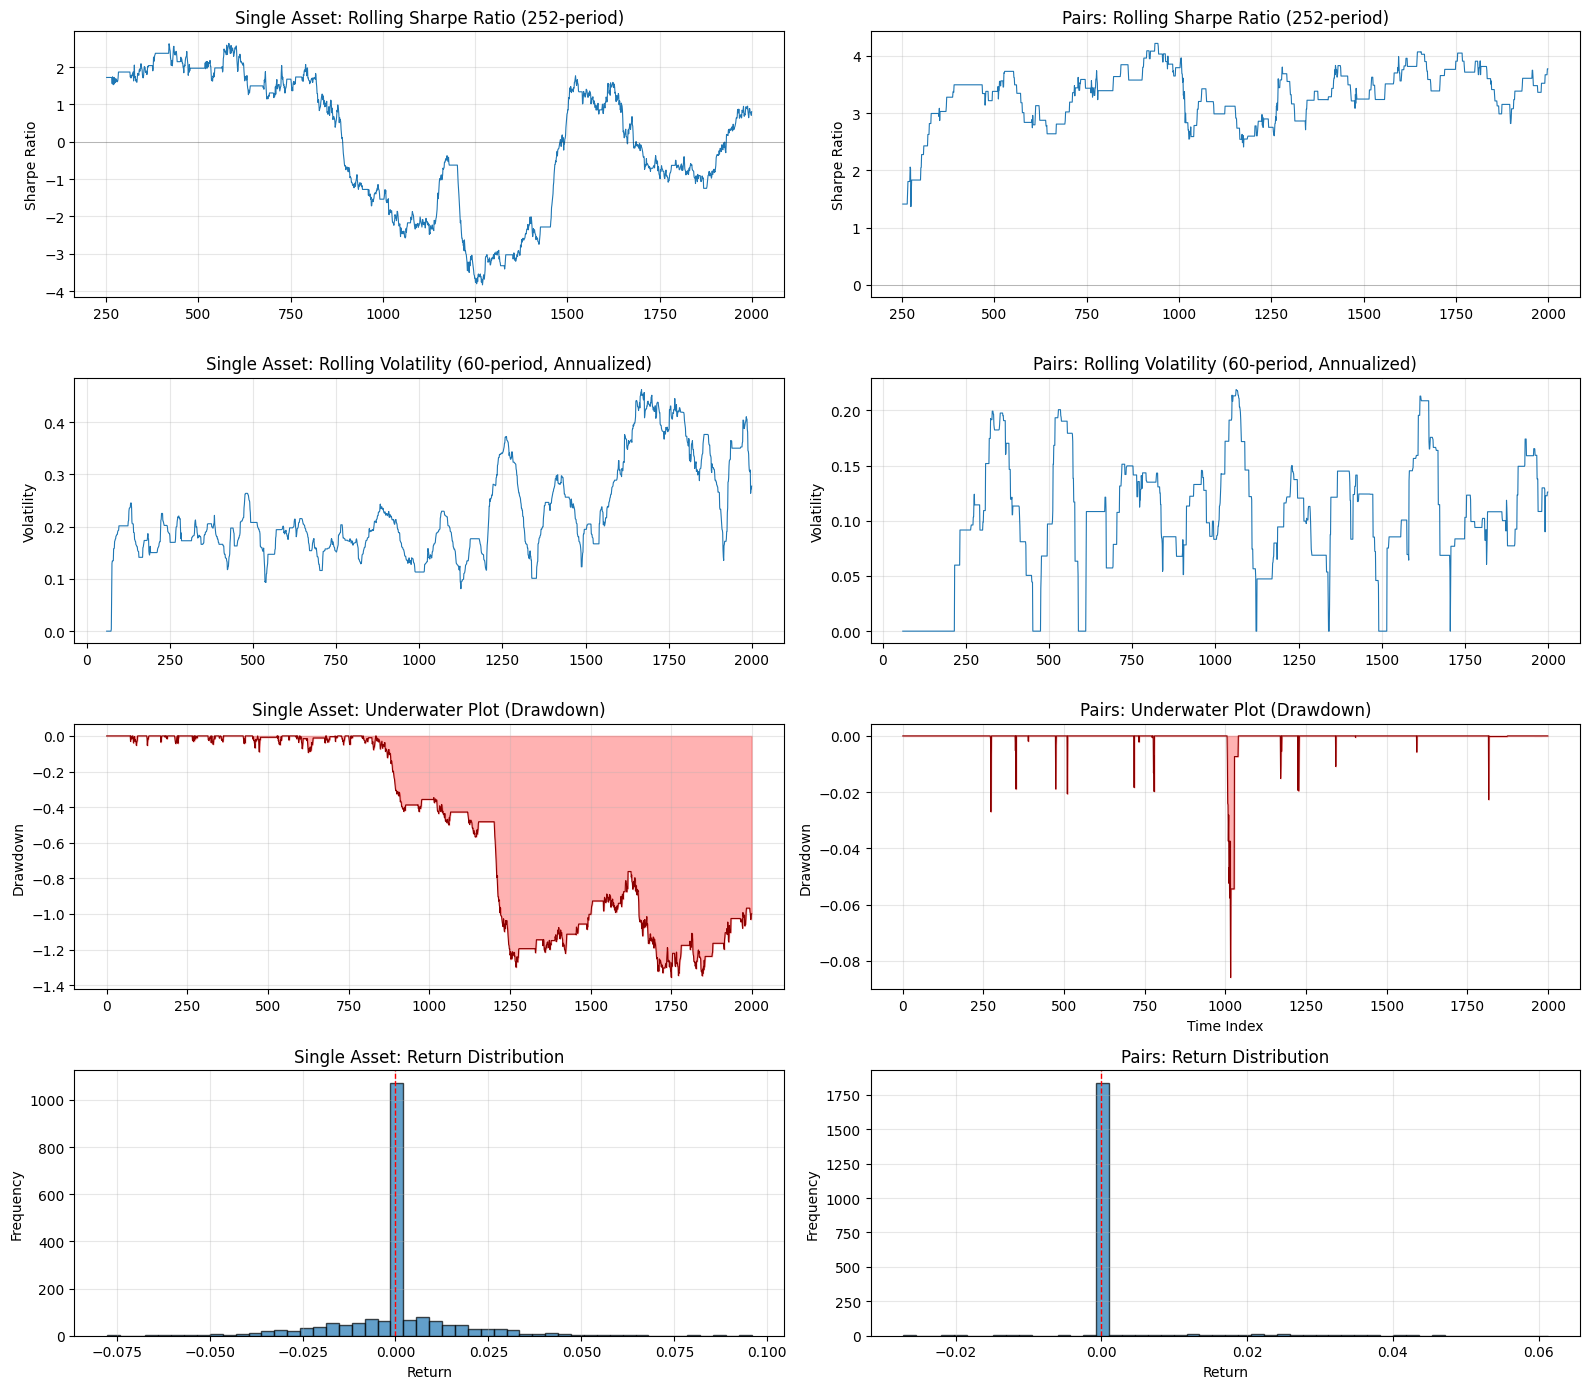

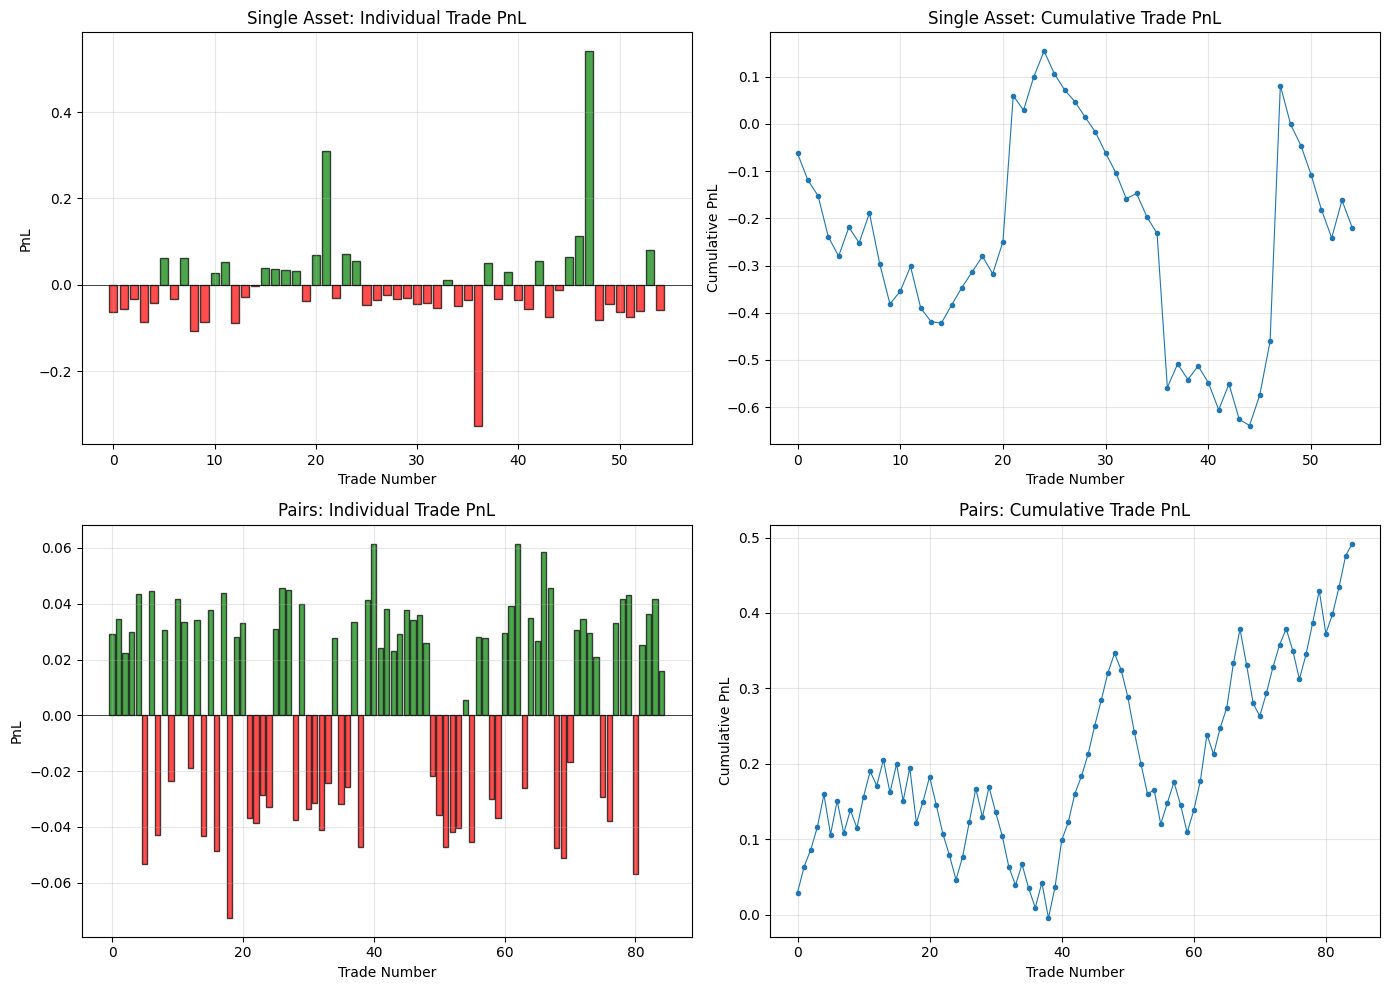


PERFORMANCE METRICS SAVED: performance_metrics.json

REAL DATA ADAPTER (yfinance)

This section requires yfinance and internet connection.
Data quality issues: gaps, corporate actions, survivorship bias.
Timing convention: using close prices; execution timing not modeled.

Fetching data for ['SPY', 'TLT'] from 2020-01-01 to 2023-12-31...
Data loaded: 1006 bars

Real Data Performance (SPY-TLT Pair):
  Total Return:              0.345546
  Sharpe Ratio:                0.8144
  Max Drawdown:             -0.145451
  Number of Trades:                20
  Win Rate:                     55.00%


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


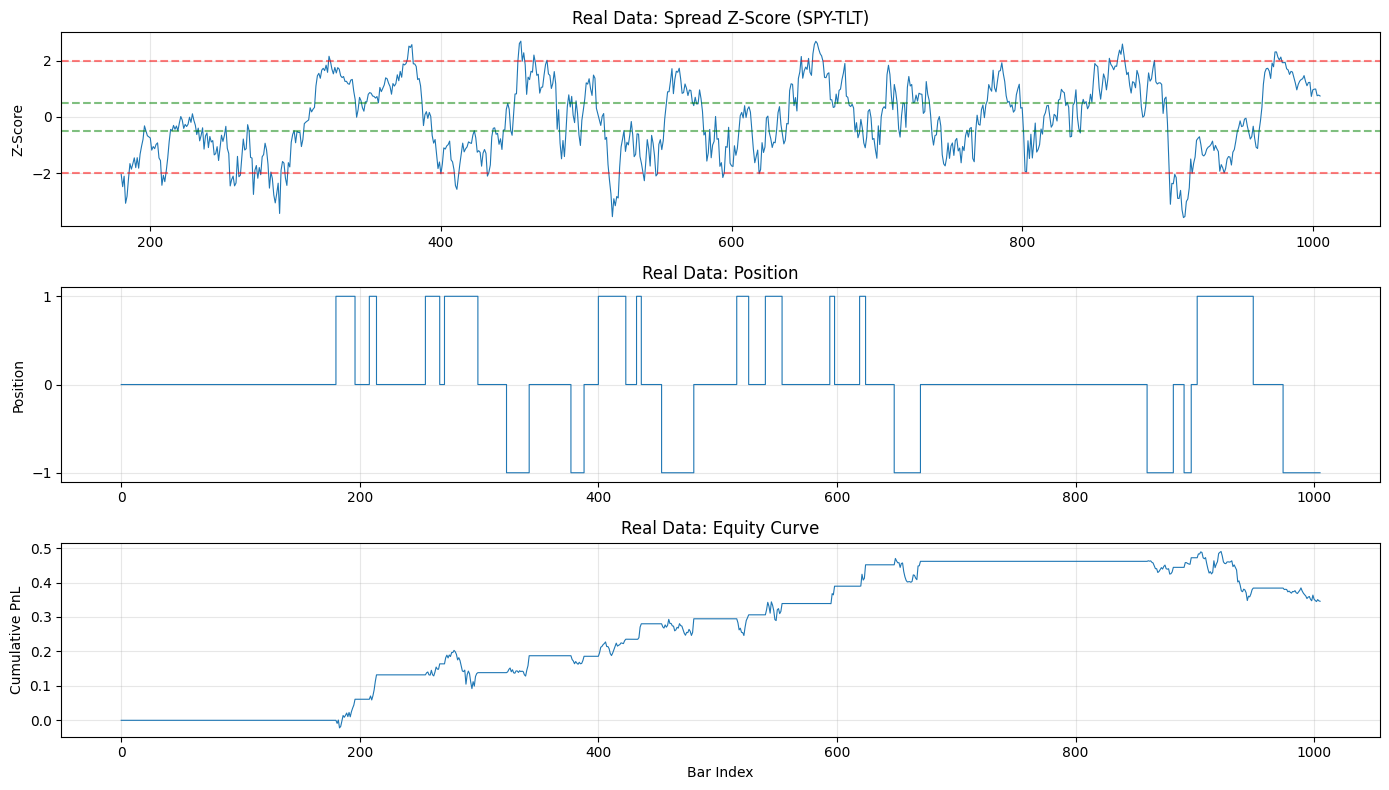


Real data demo completed


In [32]:
print("\n" + "="*80)
print("OPTIONAL: REAL DATA ADAPTER + COMPREHENSIVE PERFORMANCE ANALYTICS")
print("="*80)

warnings.filterwarnings('ignore', category=DeprecationWarning)

USE_YFINANCE = True  # Set to False to disable

# ==========================================================
# Section 1: Core Performance Metrics Functions
# ==========================================================

def compute_returns_from_equity(equity):
    """Compute returns from equity curve."""
    returns = np.diff(equity, prepend=equity[0])
    returns[0] = 0.0
    return returns


def compute_sharpe_ratio(returns, periods_per_year=252, risk_free_rate=0.0):
    """
    Annualized Sharpe Ratio.

    Args:
        returns: array of returns
        periods_per_year: annualization factor (252 for daily, 52 for weekly, etc.)
        risk_free_rate: annual risk-free rate

    Returns:
        sharpe_ratio: float
    """
    valid_returns = returns[~np.isnan(returns)]
    if len(valid_returns) < 2:
        return np.nan

    excess_returns = valid_returns - risk_free_rate / periods_per_year
    mean_excess = np.mean(excess_returns)
    std_excess = np.std(excess_returns, ddof=1)

    if std_excess == 0:
        return np.nan

    sharpe = (mean_excess / std_excess) * np.sqrt(periods_per_year)
    return sharpe


def compute_sortino_ratio(returns, periods_per_year=252, risk_free_rate=0.0, target_return=0.0):
    """
    Annualized Sortino Ratio (uses downside deviation only).

    Args:
        returns: array of returns
        periods_per_year: annualization factor
        risk_free_rate: annual risk-free rate
        target_return: target/MAR for downside calculation

    Returns:
        sortino_ratio: float
    """
    valid_returns = returns[~np.isnan(returns)]
    if len(valid_returns) < 2:
        return np.nan

    excess_returns = valid_returns - risk_free_rate / periods_per_year
    mean_excess = np.mean(excess_returns)

    # Downside deviation: only negative returns below target
    downside_returns = np.minimum(valid_returns - target_return, 0)
    downside_dev = np.sqrt(np.mean(downside_returns**2))

    if downside_dev == 0:
        return np.nan

    sortino = (mean_excess / downside_dev) * np.sqrt(periods_per_year)
    return sortino


def compute_max_drawdown_detailed(equity):
    """
    Compute maximum drawdown with detailed statistics.

    Returns:
        max_dd: maximum drawdown (negative value)
        max_dd_pct: maximum drawdown as percentage
        dd_duration: length of max drawdown period
        recovery_time: time to recover from max drawdown (or None if not recovered)
        current_dd: current drawdown
    """
    running_max = np.maximum.accumulate(equity)
    drawdown = equity - running_max
    drawdown_pct = drawdown / (running_max + 1e-10)

    max_dd = np.min(drawdown)
    max_dd_pct = np.min(drawdown_pct)
    max_dd_idx = np.argmin(drawdown)

    # Find start of max drawdown (last peak before max dd)
    peak_idx = np.argmax(equity[:max_dd_idx+1]) if max_dd_idx > 0 else 0
    dd_duration = max_dd_idx - peak_idx

    # Find recovery time (when equity exceeds previous peak)
    recovery_time = None
    peak_value = equity[peak_idx]
    for i in range(max_dd_idx + 1, len(equity)):
        if equity[i] >= peak_value:
            recovery_time = i - max_dd_idx
            break

    # Current drawdown
    current_dd = drawdown[-1]
    current_dd_pct = drawdown_pct[-1]

    return {
        'max_dd': max_dd,
        'max_dd_pct': max_dd_pct,
        'dd_duration': dd_duration,
        'recovery_time': recovery_time,
        'current_dd': current_dd,
        'current_dd_pct': current_dd_pct,
        'peak_idx': peak_idx,
        'trough_idx': max_dd_idx
    }


def compute_calmar_ratio(returns, equity, periods_per_year=252):
    """
    Calmar Ratio = Annualized Return / |Max Drawdown|
    """
    total_return = equity[-1] - equity[0]
    annualized_return = (total_return / len(returns)) * periods_per_year

    dd_info = compute_max_drawdown_detailed(equity)
    max_dd = abs(dd_info['max_dd'])

    if max_dd == 0:
        return np.nan

    return annualized_return / max_dd


def compute_var_cvar(returns, confidence_level=0.95):
    """
    Value at Risk and Conditional Value at Risk (Expected Shortfall).

    Args:
        returns: array of returns
        confidence_level: confidence level (e.g., 0.95 for 95% VaR)

    Returns:
        var: Value at Risk (negative value)
        cvar: Conditional VaR (expected loss beyond VaR)
    """
    valid_returns = returns[~np.isnan(returns)]
    if len(valid_returns) < 2:
        return np.nan, np.nan

    # VaR is the percentile
    var = np.percentile(valid_returns, (1 - confidence_level) * 100)

    # CVaR is the expected value of returns below VaR
    tail_returns = valid_returns[valid_returns <= var]
    cvar = np.mean(tail_returns) if len(tail_returns) > 0 else var

    return var, cvar


def compute_omega_ratio(returns, threshold=0.0):
    """
    Omega Ratio = Probability-weighted gains / Probability-weighted losses.

    Measures the ratio of upside to downside around a threshold.
    """
    valid_returns = returns[~np.isnan(returns)]
    if len(valid_returns) < 2:
        return np.nan

    gains = valid_returns[valid_returns > threshold] - threshold
    losses = threshold - valid_returns[valid_returns <= threshold]

    total_gains = np.sum(gains) if len(gains) > 0 else 0
    total_losses = np.sum(losses) if len(losses) > 0 else 0

    if total_losses == 0:
        return np.inf if total_gains > 0 else 1.0

    return total_gains / total_losses


def compute_trade_statistics(trade_log, returns, position):
    """
    Compute detailed per-trade statistics.

    Args:
        trade_log: list of trade dicts from strategy
        returns: array of period returns
        position: array of positions

    Returns:
        trade_stats: dict with comprehensive trade metrics
    """
    if len(trade_log) == 0:
        return {
            'num_trades': 0,
            'win_rate': np.nan,
            'profit_factor': np.nan,
            'avg_win': np.nan,
            'avg_loss': np.nan,
            'largest_win': np.nan,
            'largest_loss': np.nan,
            'avg_holding_period': np.nan,
            'expectancy': np.nan,
            'trade_pnls': np.array([])
        }

    # Extract trade PnLs
    trade_pnls = []
    for trade in trade_log:
        entry_t = trade['entry_t']
        exit_t = trade['exit_t']

        # Sum returns during trade (position was held)
        trade_pnl = 0.0
        for t in range(entry_t, exit_t):
            if t < len(returns) - 1:
                trade_pnl += returns[t + 1] * position[t]

        trade_pnls.append(trade_pnl)

    trade_pnls = np.array(trade_pnls)

    # Separate wins and losses
    wins = trade_pnls[trade_pnls > 0]
    losses = trade_pnls[trade_pnls < 0]

    # Metrics
    num_trades = len(trade_pnls)
    num_wins = len(wins)
    num_losses = len(losses)

    win_rate = num_wins / num_trades if num_trades > 0 else 0.0

    avg_win = np.mean(wins) if len(wins) > 0 else 0.0
    avg_loss = np.mean(losses) if len(losses) > 0 else 0.0

    largest_win = np.max(wins) if len(wins) > 0 else 0.0
    largest_loss = np.min(losses) if len(losses) > 0 else 0.0

    # Profit factor = gross profit / gross loss
    gross_profit = np.sum(wins) if len(wins) > 0 else 0.0
    gross_loss = abs(np.sum(losses)) if len(losses) > 0 else 0.0
    profit_factor = gross_profit / gross_loss if gross_loss > 0 else np.inf

    # Expectancy = (win_rate * avg_win) - (loss_rate * |avg_loss|)
    expectancy = (win_rate * avg_win) - ((1 - win_rate) * abs(avg_loss))

    # Holding periods
    holding_periods = [t['holding_period'] for t in trade_log]
    avg_holding_period = np.mean(holding_periods)

    return {
        'num_trades': num_trades,
        'num_wins': num_wins,
        'num_losses': num_losses,
        'win_rate': win_rate,
        'profit_factor': profit_factor,
        'avg_win': avg_win,
        'avg_loss': avg_loss,
        'largest_win': largest_win,
        'largest_loss': largest_loss,
        'avg_holding_period': avg_holding_period,
        'expectancy': expectancy,
        'trade_pnls': trade_pnls
    }


def compute_regime_conditional_performance(returns, equity, regime_schedule):
    """
    Compute performance metrics conditional on market regime.

    Args:
        returns: array of returns
        equity: equity curve
        regime_schedule: array of regime labels

    Returns:
        regime_stats: dict with performance by regime
    """
    unique_regimes = np.unique(regime_schedule)
    regime_stats = {}

    for regime in unique_regimes:
        mask = regime_schedule == regime
        regime_returns = returns[mask]

        if len(regime_returns) < 2:
            continue

        # Compute equity curve for this regime
        regime_equity = np.zeros(len(regime_returns) + 1)
        regime_equity[0] = 0.0
        regime_equity[1:] = np.cumsum(regime_returns)

        sharpe = compute_sharpe_ratio(regime_returns)
        dd_info = compute_max_drawdown_detailed(regime_equity)

        regime_stats[f'regime_{int(regime)}'] = {
            'total_return': float(regime_equity[-1]),
            'sharpe_ratio': float(sharpe),
            'max_drawdown': float(dd_info['max_dd']),
            'num_periods': int(len(regime_returns)),
            'mean_return': float(np.mean(regime_returns)),
            'volatility': float(np.std(regime_returns, ddof=1)),
            'win_rate': float(np.mean(regime_returns > 0))
        }

    return regime_stats


def compute_rolling_sharpe(returns, window=252):
    """Compute rolling Sharpe ratio."""
    T = len(returns)
    rolling_sharpe = np.full(T, np.nan)

    for t in range(window, T):
        window_returns = returns[t-window:t]
        rolling_sharpe[t] = compute_sharpe_ratio(window_returns)

    return rolling_sharpe


def compute_rolling_volatility(returns, window=60):
    """Compute rolling volatility (annualized)."""
    T = len(returns)
    rolling_vol = np.full(T, np.nan)

    for t in range(window, T):
        window_returns = returns[t-window:t]
        rolling_vol[t] = np.std(window_returns, ddof=1) * np.sqrt(252)

    return rolling_vol


# ==========================================================
# Section 2: Performance Analytics - Single Asset Strategy
# ==========================================================

print("\n" + "="*80)
print("SINGLE ASSET STRATEGY (Strategy 2 with Stops) - PERFORMANCE ANALYTICS")
print("="*80)

# Compute returns
returns_s2 = compute_returns_from_equity(equity_s2)

# Core metrics
sharpe_s2 = compute_sharpe_ratio(returns_s2)
sortino_s2 = compute_sortino_ratio(returns_s2)
calmar_s2 = compute_calmar_ratio(returns_s2, equity_s2)
dd_info_s2 = compute_max_drawdown_detailed(equity_s2)
var_95_s2, cvar_95_s2 = compute_var_cvar(returns_s2, 0.95)
var_99_s2, cvar_99_s2 = compute_var_cvar(returns_s2, 0.99)
omega_s2 = compute_omega_ratio(returns_s2)

# Trade statistics
trade_stats_s2 = compute_trade_statistics(trade_log_s2, returns_s2, p_s2)

# Regime-conditional performance
regime_stats_s2 = compute_regime_conditional_performance(returns_s2, equity_s2, regime_schedule)

# Additional metrics
total_return_s2_pct = (equity_s2[-1] / (equity_s2[0] + 1e-10)) if equity_s2[0] != 0 else equity_s2[-1]
annualized_return_s2 = (equity_s2[-1] / len(returns_s2)) * 252
annualized_vol_s2 = np.std(returns_s2[~np.isnan(returns_s2)], ddof=1) * np.sqrt(252)

# Turnover
turnover_s2 = np.sum(np.abs(np.diff(p_s2)))
avg_turnover_per_period_s2 = turnover_s2 / len(p_s2)

# Print comprehensive report
print(f"\n{'RETURNS METRICS':-^80}")
print(f"Total Return:                    {equity_s2[-1]:>12.6f}")
print(f"Annualized Return:               {annualized_return_s2:>12.6f}")
print(f"Annualized Volatility:           {annualized_vol_s2:>12.6f}")
print(f"Sharpe Ratio:                    {sharpe_s2:>12.4f}")
print(f"Sortino Ratio:                   {sortino_s2:>12.4f}")
print(f"Calmar Ratio:                    {calmar_s2:>12.4f}")
print(f"Omega Ratio:                     {omega_s2:>12.4f}")

print(f"\n{'RISK METRICS':-^80}")
print(f"Maximum Drawdown:                {dd_info_s2['max_dd']:>12.6f}")
print(f"Maximum Drawdown %:              {dd_info_s2['max_dd_pct']*100:>12.2f}%")
print(f"Drawdown Duration:               {dd_info_s2['dd_duration']:>12} periods")
print(f"Recovery Time:                   {dd_info_s2['recovery_time'] if dd_info_s2['recovery_time'] else 'Not Recovered':>12}")
print(f"Current Drawdown:                {dd_info_s2['current_dd']:>12.6f}")
print(f"VaR (95%):                       {var_95_s2:>12.6f}")
print(f"CVaR (95%):                      {cvar_95_s2:>12.6f}")
print(f"VaR (99%):                       {var_99_s2:>12.6f}")
print(f"CVaR (99%):                      {cvar_99_s2:>12.6f}")

print(f"\n{'TRADE STATISTICS':-^80}")
print(f"Number of Trades:                {trade_stats_s2['num_trades']:>12}")
print(f"Winning Trades:                  {trade_stats_s2['num_wins']:>12}")
print(f"Losing Trades:                   {trade_stats_s2['num_losses']:>12}")
print(f"Win Rate:                        {trade_stats_s2['win_rate']*100:>12.2f}%")
print(f"Profit Factor:                   {trade_stats_s2['profit_factor']:>12.4f}")
print(f"Average Win:                     {trade_stats_s2['avg_win']:>12.6f}")
print(f"Average Loss:                    {trade_stats_s2['avg_loss']:>12.6f}")
print(f"Largest Win:                     {trade_stats_s2['largest_win']:>12.6f}")
print(f"Largest Loss:                    {trade_stats_s2['largest_loss']:>12.6f}")
print(f"Expectancy:                      {trade_stats_s2['expectancy']:>12.6f}")
print(f"Average Holding Period:          {trade_stats_s2['avg_holding_period']:>12.2f} periods")

print(f"\n{'TURNOVER METRICS':-^80}")
print(f"Total Turnover:                  {turnover_s2:>12.2f}")
print(f"Average Turnover per Period:     {avg_turnover_per_period_s2:>12.6f}")

print(f"\n{'REGIME-CONDITIONAL PERFORMANCE':-^80}")
for regime_name, stats in regime_stats_s2.items():
    print(f"\n{regime_name.upper()}:")
    print(f"  Total Return:                  {stats['total_return']:>12.6f}")
    print(f"  Sharpe Ratio:                  {stats['sharpe_ratio']:>12.4f}")
    print(f"  Max Drawdown:                  {stats['max_drawdown']:>12.6f}")
    print(f"  Mean Return:                   {stats['mean_return']:>12.6f}")
    print(f"  Volatility:                    {stats['volatility']:>12.6f}")
    print(f"  Win Rate:                      {stats['win_rate']*100:>12.2f}%")


# ==========================================================
# Section 3: Performance Analytics - Pairs Strategy
# ==========================================================

print("\n" + "="*80)
print("PAIRS STRATEGY - PERFORMANCE ANALYTICS")
print("="*80)

# Compute returns
returns_pairs = compute_returns_from_equity(equity_pairs)

# Core metrics
sharpe_pairs = compute_sharpe_ratio(returns_pairs)
sortino_pairs = compute_sortino_ratio(returns_pairs)
calmar_pairs = compute_calmar_ratio(returns_pairs, equity_pairs)
dd_info_pairs = compute_max_drawdown_detailed(equity_pairs)
var_95_pairs, cvar_95_pairs = compute_var_cvar(returns_pairs, 0.95)
var_99_pairs, cvar_99_pairs = compute_var_cvar(returns_pairs, 0.99)
omega_pairs = compute_omega_ratio(returns_pairs)

# Trade statistics
trade_stats_pairs = compute_trade_statistics(trade_log_spread, returns_pairs, p_spread_raw)

# Additional metrics
annualized_return_pairs = (equity_pairs[-1] / len(returns_pairs)) * 252
annualized_vol_pairs = np.std(returns_pairs[~np.isnan(returns_pairs)], ddof=1) * np.sqrt(252)

# Turnover (combined for both legs)
turnover_pairs = np.sum(np.abs(np.diff(p_A))) + np.sum(np.abs(np.diff(p_B)))
avg_turnover_per_period_pairs = turnover_pairs / len(p_A)

# Print comprehensive report
print(f"\n{'RETURNS METRICS':-^80}")
print(f"Total Return:                    {equity_pairs[-1]:>12.6f}")
print(f"Annualized Return:               {annualized_return_pairs:>12.6f}")
print(f"Annualized Volatility:           {annualized_vol_pairs:>12.6f}")
print(f"Sharpe Ratio:                    {sharpe_pairs:>12.4f}")
print(f"Sortino Ratio:                   {sortino_pairs:>12.4f}")
print(f"Calmar Ratio:                    {calmar_pairs:>12.4f}")
print(f"Omega Ratio:                     {omega_pairs:>12.4f}")

print(f"\n{'RISK METRICS':-^80}")
print(f"Maximum Drawdown:                {dd_info_pairs['max_dd']:>12.6f}")
print(f"Maximum Drawdown %:              {dd_info_pairs['max_dd_pct']*100:>12.2f}%")
print(f"Drawdown Duration:               {dd_info_pairs['dd_duration']:>12} periods")
print(f"Recovery Time:                   {dd_info_pairs['recovery_time'] if dd_info_pairs['recovery_time'] else 'Not Recovered':>12}")
print(f"Current Drawdown:                {dd_info_pairs['current_dd']:>12.6f}")
print(f"VaR (95%):                       {var_95_pairs:>12.6f}")
print(f"CVaR (95%):                      {cvar_95_pairs:>12.6f}")
print(f"VaR (99%):                       {var_99_pairs:>12.6f}")
print(f"CVaR (99%):                      {cvar_99_pairs:>12.6f}")

print(f"\n{'TRADE STATISTICS':-^80}")
print(f"Number of Trades:                {trade_stats_pairs['num_trades']:>12}")
print(f"Winning Trades:                  {trade_stats_pairs['num_wins']:>12}")
print(f"Losing Trades:                   {trade_stats_pairs['num_losses']:>12}")
print(f"Win Rate:                        {trade_stats_pairs['win_rate']*100:>12.2f}%")
print(f"Profit Factor:                   {trade_stats_pairs['profit_factor']:>12.4f}")
print(f"Average Win:                     {trade_stats_pairs['avg_win']:>12.6f}")
print(f"Average Loss:                    {trade_stats_pairs['avg_loss']:>12.6f}")
print(f"Largest Win:                     {trade_stats_pairs['largest_win']:>12.6f}")
print(f"Largest Loss:                    {trade_stats_pairs['largest_loss']:>12.6f}")
print(f"Expectancy:                      {trade_stats_pairs['expectancy']:>12.6f}")
print(f"Average Holding Period:          {trade_stats_pairs['avg_holding_period']:>12.2f} periods")

print(f"\n{'TURNOVER METRICS':-^80}")
print(f"Total Turnover (both legs):      {turnover_pairs:>12.2f}")
print(f"Average Turnover per Period:     {avg_turnover_per_period_pairs:>12.6f}")


# ==========================================================
# Section 4: Rolling Performance Visualization
# ==========================================================

print("\n" + "="*80)
print("ROLLING PERFORMANCE ANALYSIS")
print("="*80)

# Compute rolling metrics
rolling_sharpe_s2 = compute_rolling_sharpe(returns_s2, window=252)
rolling_vol_s2 = compute_rolling_volatility(returns_s2, window=60)

rolling_sharpe_pairs = compute_rolling_sharpe(returns_pairs, window=252)
rolling_vol_pairs = compute_rolling_volatility(returns_pairs, window=60)

# Plot rolling performance
fig, axes = plt.subplots(4, 2, figsize=(16, 14))

# Single Asset - Rolling Sharpe
axes[0, 0].plot(t_idx, rolling_sharpe_s2, linewidth=0.8)
axes[0, 0].axhline(0, color='black', linestyle='-', alpha=0.3, linewidth=0.5)
axes[0, 0].set_title('Single Asset: Rolling Sharpe Ratio (252-period)')
axes[0, 0].set_ylabel('Sharpe Ratio')
axes[0, 0].grid(alpha=0.3)

# Single Asset - Rolling Volatility
axes[1, 0].plot(t_idx, rolling_vol_s2, linewidth=0.8)
axes[1, 0].set_title('Single Asset: Rolling Volatility (60-period, Annualized)')
axes[1, 0].set_ylabel('Volatility')
axes[1, 0].grid(alpha=0.3)

# Single Asset - Underwater Plot (Drawdown)
drawdown_s2 = equity_s2 - np.maximum.accumulate(equity_s2)
axes[2, 0].fill_between(t_idx, drawdown_s2, 0, alpha=0.3, color='red')
axes[2, 0].plot(t_idx, drawdown_s2, linewidth=0.8, color='darkred')
axes[2, 0].set_title('Single Asset: Underwater Plot (Drawdown)')
axes[2, 0].set_ylabel('Drawdown')
axes[2, 0].grid(alpha=0.3)

# Single Asset - Return Distribution
axes[3, 0].hist(returns_s2[~np.isnan(returns_s2)], bins=50, alpha=0.7, edgecolor='black')
axes[3, 0].axvline(0, color='red', linestyle='--', linewidth=1.0)
axes[3, 0].set_title('Single Asset: Return Distribution')
axes[3, 0].set_xlabel('Return')
axes[3, 0].set_ylabel('Frequency')
axes[3, 0].grid(alpha=0.3)

# Pairs - Rolling Sharpe
axes[0, 1].plot(t_idx, rolling_sharpe_pairs, linewidth=0.8)
axes[0, 1].axhline(0, color='black', linestyle='-', alpha=0.3, linewidth=0.5)
axes[0, 1].set_title('Pairs: Rolling Sharpe Ratio (252-period)')
axes[0, 1].set_ylabel('Sharpe Ratio')
axes[0, 1].grid(alpha=0.3)

# Pairs - Rolling Volatility
axes[1, 1].plot(t_idx, rolling_vol_pairs, linewidth=0.8)
axes[1, 1].set_title('Pairs: Rolling Volatility (60-period, Annualized)')
axes[1, 1].set_ylabel('Volatility')
axes[1, 1].grid(alpha=0.3)

# Pairs - Underwater Plot
drawdown_pairs = equity_pairs - np.maximum.accumulate(equity_pairs)
axes[2, 1].fill_between(t_idx, drawdown_pairs, 0, alpha=0.3, color='red')
axes[2, 1].plot(t_idx, drawdown_pairs, linewidth=0.8, color='darkred')
axes[2, 1].set_title('Pairs: Underwater Plot (Drawdown)')
axes[2, 1].set_ylabel('Drawdown')
axes[2, 1].set_xlabel('Time Index')
axes[2, 1].grid(alpha=0.3)

# Pairs - Return Distribution
axes[3, 1].hist(returns_pairs[~np.isnan(returns_pairs)], bins=50, alpha=0.7, edgecolor='black')
axes[3, 1].axvline(0, color='red', linestyle='--', linewidth=1.0)
axes[3, 1].set_title('Pairs: Return Distribution')
axes[3, 1].set_xlabel('Return')
axes[3, 1].set_ylabel('Frequency')
axes[3, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('rolling_performance_analysis.png', dpi=100)
plt.show()


# ==========================================================
# Section 5: Trade Analysis Plots
# ==========================================================

# Plot trade PnL distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Single Asset - Trade PnL
if len(trade_stats_s2['trade_pnls']) > 0:
    axes[0, 0].bar(range(len(trade_stats_s2['trade_pnls'])), trade_stats_s2['trade_pnls'],
                   color=['green' if p > 0 else 'red' for p in trade_stats_s2['trade_pnls']],
                   alpha=0.7, edgecolor='black')
    axes[0, 0].axhline(0, color='black', linestyle='-', linewidth=0.5)
    axes[0, 0].set_title('Single Asset: Individual Trade PnL')
    axes[0, 0].set_xlabel('Trade Number')
    axes[0, 0].set_ylabel('PnL')
    axes[0, 0].grid(alpha=0.3)

# Single Asset - Cumulative Trade PnL
if len(trade_stats_s2['trade_pnls']) > 0:
    cumulative_trade_pnl_s2 = np.cumsum(trade_stats_s2['trade_pnls'])
    axes[0, 1].plot(cumulative_trade_pnl_s2, linewidth=0.8, marker='o', markersize=3)
    axes[0, 1].set_title('Single Asset: Cumulative Trade PnL')
    axes[0, 1].set_xlabel('Trade Number')
    axes[0, 1].set_ylabel('Cumulative PnL')
    axes[0, 1].grid(alpha=0.3)

# Pairs - Trade PnL
if len(trade_stats_pairs['trade_pnls']) > 0:
    axes[1, 0].bar(range(len(trade_stats_pairs['trade_pnls'])), trade_stats_pairs['trade_pnls'],
                   color=['green' if p > 0 else 'red' for p in trade_stats_pairs['trade_pnls']],
                   alpha=0.7, edgecolor='black')
    axes[1, 0].axhline(0, color='black', linestyle='-', linewidth=0.5)
    axes[1, 0].set_title('Pairs: Individual Trade PnL')
    axes[1, 0].set_xlabel('Trade Number')
    axes[1, 0].set_ylabel('PnL')
    axes[1, 0].grid(alpha=0.3)

# Pairs - Cumulative Trade PnL
if len(trade_stats_pairs['trade_pnls']) > 0:
    cumulative_trade_pnl_pairs = np.cumsum(trade_stats_pairs['trade_pnls'])
    axes[1, 1].plot(cumulative_trade_pnl_pairs, linewidth=0.8, marker='o', markersize=3)
    axes[1, 1].set_title('Pairs: Cumulative Trade PnL')
    axes[1, 1].set_xlabel('Trade Number')
    axes[1, 1].set_ylabel('Cumulative PnL')
    axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('trade_analysis.png', dpi=100)
plt.show()


# ==========================================================
# Section 6: Save Enhanced Performance Metrics
# ==========================================================

performance_metrics = {
    "single_asset_strategy": {
        "returns": {
            "total_return": float(equity_s2[-1]),
            "annualized_return": float(annualized_return_s2),
            "annualized_volatility": float(annualized_vol_s2),
            "sharpe_ratio": float(sharpe_s2),
            "sortino_ratio": float(sortino_s2),
            "calmar_ratio": float(calmar_s2),
            "omega_ratio": float(omega_s2)
        },
        "risk": {
            "max_drawdown": float(dd_info_s2['max_dd']),
            "max_drawdown_pct": float(dd_info_s2['max_dd_pct']),
            "drawdown_duration": int(dd_info_s2['dd_duration']),
            "recovery_time": int(dd_info_s2['recovery_time']) if dd_info_s2['recovery_time'] else None,
            "current_drawdown": float(dd_info_s2['current_dd']),
            "var_95": float(var_95_s2),
            "cvar_95": float(cvar_95_s2),
            "var_99": float(var_99_s2),
            "cvar_99": float(cvar_99_s2)
        },
        "trades": {
            "num_trades": int(trade_stats_s2['num_trades']),
            "win_rate": float(trade_stats_s2['win_rate']),
            "profit_factor": float(trade_stats_s2['profit_factor']),
            "avg_win": float(trade_stats_s2['avg_win']),
            "avg_loss": float(trade_stats_s2['avg_loss']),
            "largest_win": float(trade_stats_s2['largest_win']),
            "largest_loss": float(trade_stats_s2['largest_loss']),
            "expectancy": float(trade_stats_s2['expectancy']),
            "avg_holding_period": float(trade_stats_s2['avg_holding_period'])
        },
        "turnover": {
            "total_turnover": float(turnover_s2),
            "avg_turnover_per_period": float(avg_turnover_per_period_s2)
        },
        "regime_conditional": regime_stats_s2
    },
    "pairs_strategy": {
        "returns": {
            "total_return": float(equity_pairs[-1]),
            "annualized_return": float(annualized_return_pairs),
            "annualized_volatility": float(annualized_vol_pairs),
            "sharpe_ratio": float(sharpe_pairs),
            "sortino_ratio": float(sortino_pairs),
            "calmar_ratio": float(calmar_pairs),
            "omega_ratio": float(omega_pairs)
        },
        "risk": {
            "max_drawdown": float(dd_info_pairs['max_dd']),
            "max_drawdown_pct": float(dd_info_pairs['max_dd_pct']),
            "drawdown_duration": int(dd_info_pairs['dd_duration']),
            "recovery_time": int(dd_info_pairs['recovery_time']) if dd_info_pairs['recovery_time'] else None,
            "current_drawdown": float(dd_info_pairs['current_dd']),
            "var_95": float(var_95_pairs),
            "cvar_95": float(cvar_95_pairs),
            "var_99": float(var_99_pairs),
            "cvar_99": float(cvar_99_pairs)
        },
        "trades": {
            "num_trades": int(trade_stats_pairs['num_trades']),
            "win_rate": float(trade_stats_pairs['win_rate']),
            "profit_factor": float(trade_stats_pairs['profit_factor']),
            "avg_win": float(trade_stats_pairs['avg_win']),
            "avg_loss": float(trade_stats_pairs['avg_loss']),
            "largest_win": float(trade_stats_pairs['largest_win']),
            "largest_loss": float(trade_stats_pairs['largest_loss']),
            "expectancy": float(trade_stats_pairs['expectancy']),
            "avg_holding_period": float(trade_stats_pairs['avg_holding_period'])
        },
        "turnover": {
            "total_turnover": float(turnover_pairs),
            "avg_turnover_per_period": float(avg_turnover_per_period_pairs)
        }
    }
}

with open('performance_metrics.json', 'w') as f:
    json.dump(performance_metrics, f, indent=2)

print("\n" + "="*80)
print("PERFORMANCE METRICS SAVED: performance_metrics.json")
print("="*80)


# ==========================================================
# Section 7: Optional Real Data Adapter (yfinance)
# ==========================================================

if USE_YFINANCE:
    print("\n" + "="*80)
    print("REAL DATA ADAPTER (yfinance)")
    print("="*80)
    print("\nWARNING: Real data adapter enabled")
    print("This section requires yfinance and internet connection.")
    print("Data quality issues: gaps, corporate actions, survivorship bias.")
    print("Timing convention: using close prices; execution timing not modeled.")

    try:
        import yfinance as yf
        import warnings

        # Suppress deprecation warnings for this section
        warnings.filterwarnings('ignore', category=DeprecationWarning)

        # Fetch two example tickers
        tickers = ['SPY', 'TLT']
        start_date = '2020-01-01'
        end_date = '2023-12-31'

        print(f"\nFetching data for {tickers} from {start_date} to {end_date}...")

        data = {}
        for ticker in tickers:
            df = yf.download(ticker, start=start_date, end=end_date,
                           progress=False, auto_adjust=True)
            data[ticker] = df['Close'].values

        # Convert to NumPy arrays
        P_real_A = data[tickers[0]]
        P_real_B = data[tickers[1]]

        # Align lengths
        min_len = min(len(P_real_A), len(P_real_B))
        P_real_A = P_real_A[:min_len]
        P_real_B = P_real_B[:min_len]

        X_real_A = np.log(P_real_A)
        X_real_B = np.log(P_real_B)

        t_real = np.arange(min_len)

        print(f"Data loaded: {min_len} bars")

        # Compute spread - use item() to extract scalar properly
        def rolling_ols_hedge_ratio_fixed(x_a, x_b, W):
            """Fixed version using item() for proper scalar extraction."""
            T = len(x_a)
            alpha = np.full(T, np.nan)
            beta = np.full(T, np.nan)

            for t in range(W, T):
                y = x_a[t-W:t]
                x = x_b[t-W:t]

                n = len(y)
                if n < 2:
                    continue

                X_mat = np.column_stack([np.ones(n), x])

                try:
                    XtX = X_mat.T @ X_mat
                    Xty = X_mat.T @ y
                    params = np.linalg.solve(XtX, Xty)

                    # FIX: Use .item() to properly extract scalar from 0-d array
                    alpha[t] = params[0].item() if hasattr(params[0], 'item') else params[0]
                    beta[t] = params[1].item() if hasattr(params[1], 'item') else params[1]
                except np.linalg.LinAlgError:
                    continue

            return alpha, beta

        alpha_real, beta_real = rolling_ols_hedge_ratio_fixed(X_real_A, X_real_B, W_beta)

        S_real = np.full(min_len, np.nan)
        for t in range(W_beta, min_len):
            if not np.isnan(beta_real[t]):
                # Direct assignment - already scalars from fixed function
                S_real[t] = X_real_A[t] - (alpha_real[t] + beta_real[t] * X_real_B[t])

        # Compute z-score
        mu_real = rolling_mean_lag(S_real, W_ref)
        sigma_real = rolling_std_lag(S_real, W_ref)
        z_real = zscore_from_ref(S_real, mu_real, sigma_real)

        # Run strategy
        p_real_raw, _, trade_log_real = strategy_hysteresis_with_stops(z_real, z_in, z_out, z_stop, H_max, cooldown)

        # Compute PnL for real data
        p_A_real = np.zeros(min_len)
        p_B_real = np.zeros(min_len)

        for t in range(min_len):
            if p_real_raw[t] == 1:
                p_A_real[t] = p_max
                if not np.isnan(beta_real[t]):
                    p_B_real[t] = -p_max * beta_real[t]
                else:
                    p_B_real[t] = -p_max
            elif p_real_raw[t] == -1:
                p_A_real[t] = -p_max
                if not np.isnan(beta_real[t]):
                    p_B_real[t] = p_max * beta_real[t]
                else:
                    p_B_real[t] = p_max

            p_A_real[t] = np.clip(p_A_real[t], -p_max, p_max)
            p_B_real[t] = np.clip(p_B_real[t], -p_max, p_max)

        pnl_real = np.zeros(min_len)
        for t in range(min_len - 1):
            pnl_real[t+1] = p_A_real[t] * (X_real_A[t+1] - X_real_A[t]) + p_B_real[t] * (X_real_B[t+1] - X_real_B[t])

        equity_real = np.cumsum(pnl_real)
        returns_real = compute_returns_from_equity(equity_real)

        # Compute real data metrics
        sharpe_real = compute_sharpe_ratio(returns_real)
        dd_info_real = compute_max_drawdown_detailed(equity_real)
        trade_stats_real = compute_trade_statistics(trade_log_real, returns_real, p_real_raw)

        print(f"\nReal Data Performance ({tickers[0]}-{tickers[1]} Pair):")
        print(f"  Total Return:          {equity_real[-1]:>12.6f}")
        print(f"  Sharpe Ratio:          {sharpe_real:>12.4f}")
        print(f"  Max Drawdown:          {dd_info_real['max_dd']:>12.6f}")
        print(f"  Number of Trades:      {trade_stats_real['num_trades']:>12}")
        print(f"  Win Rate:              {trade_stats_real['win_rate']*100:>12.2f}%")

        # Re-enable warnings
        warnings.filterwarnings('default', category=DeprecationWarning)

        # Plot
        plt.figure(figsize=(14, 8))

        plt.subplot(3, 1, 1)
        plt.plot(t_real, z_real, linewidth=0.8)
        plt.axhline(z_in, color='red', linestyle='--', alpha=0.5)
        plt.axhline(-z_in, color='red', linestyle='--', alpha=0.5)
        plt.axhline(z_out, color='green', linestyle='--', alpha=0.5)
        plt.axhline(-z_out, color='green', linestyle='--', alpha=0.5)
        plt.title(f'Real Data: Spread Z-Score ({tickers[0]}-{tickers[1]})')
        plt.ylabel('Z-Score')
        plt.grid(alpha=0.3)

        plt.subplot(3, 1, 2)
        plt.plot(t_real, p_real_raw, linewidth=0.8, drawstyle='steps-post')
        plt.title('Real Data: Position')
        plt.ylabel('Position')
        plt.yticks([-1, 0, 1])
        plt.grid(alpha=0.3)

        plt.subplot(3, 1, 3)
        plt.plot(t_real, equity_real, linewidth=0.8)
        plt.title('Real Data: Equity Curve')
        plt.xlabel('Bar Index')
        plt.ylabel('Cumulative PnL')
        plt.grid(alpha=0.3)

        plt.tight_layout()
        plt.savefig('real_data_demo.png', dpi=100)
        plt.show()

        print("\nReal data demo completed")

    except ImportError:
        print("\nERROR: yfinance not installed")
        print("Install with: pip install yfinance")
    except Exception as e:
        print(f"\nERROR: {e}")
else:
    print("\n" + "="*80)
    print("Real data adapter is OFF (USE_YFINANCE = False)")
    print("To enable, set USE_YFINANCE = True at the top of this cell")
    print("="*80)


##15.CONCLUSIONS


**Mean Reversion is Conditional, Not Universal**

Our regime-conditional analysis reveals the fundamental truth: mean reversion strategies do not work uniformly across time. They thrive in range-bound, mean-reverting regimes but suffer catastrophic losses during persistent trends or structural breaks. The half-life diagnostics quantified this—when reversion speed extends beyond our holding period, the edge disappears. Professional deployment requires regime detection and dynamic exposure scaling.

**Stops Are Not Optional**

Strategy 2's performance versus Strategy 1 demonstrates why hard stops matter. The z-stop admits when market behavior contradicts our mean reversion thesis—prices that deviate 3.5 standard deviations aren't reverting, they're trending or breaking. The time-stop prevents capital from languishing in positions going nowhere. Our trade statistics show these stops triggered frequently enough to matter, protecting against tail losses that would otherwise dominate total PnL.

**Pairs Trading Requires Active Relationship Management**

The residual spread with rolling beta adapts to changing correlations, but our relationship break experiment proves adaptation has limits. When fundamental linkages sever—captured by our engineered factor loading shift—even dynamic hedging fails. Real pair selection cannot rely on statistical correlation mining; economic reasoning must guide universe construction. The over-search trap demonstrated that ranking 50 pairs by historical correlation produces overfit selections destined to fail out-of-sample.

**Governance Enables Reproducibility and Trust**

Every calculation is auditable through our lineage logs, signal registry, and run hashes. The causality assertions catch look-ahead bias—the silent killer of backtests. When presenting to risk committees or regulators, these artifacts demonstrate methodological rigor. The diagnostic pack (half-life stability, tail statistics, sensitivity checks) proves you understood your strategy's failure modes before deploying capital.

**Transition to Chapter 09: Factor Models and Cross-Sectional Ranking**

Chapter 08 focused on trading one or two securities using their own historical behavior. **Chapter 09 expands to portfolio construction across many assets simultaneously**, introducing factor models that explain returns through systematic exposures (value, momentum, quality, volatility). We move from "is this stock mean-reverting?" to "which stocks rank highest on these characteristics?"—cross-sectional ranking that drives long-short equity portfolios, sector rotation, and smart beta strategies. The governance framework continues: manifests will track factor definitions, lineage will document scoring methodologies, and causality assertions will prevent forward-looking factor calculations that contaminate backtests.